# Drug Induced Liver Injury pyramidal prediction protocol:
### Combining Molecular Descriptors and Clinical Adverse effects to develop Adverse effects models for predicting DILI.

# Importing libraries

In [1]:
import pandas as pd
from rdkit.Chem import PandasTools as pt
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("ticks")

from rdkit.Chem import AllChem
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import matthews_corrcoef as mcc
from sklearn.cross_decomposition import PLSRegression

In [2]:
# Import Flame and RDKit libraries

from flame.build import Build
from flame.predict import Predict
from flame.manage import *
from rdkit.Chem import PandasTools as pt
pd.options.display.max_columns = None

%config Completer.use_jedi=False

In [3]:
def checkAtomsCoordinates(m):
    '''
        Function to check if a molecule contains zero coordinates in all atoms. 
        Then this molecule must be eliminated.
        Returns True if molecules is OK and False if molecule contains zero coordinates.
        
        Example:
            # Load  test set to a frame
            pfizersdf = 'validations_sets/pfizer-3Dprot-info.sdf'
            pfizer_val = pt.LoadSDF(pfizersdf, molColName='mol3DProt')
            ## Checking if molecule contains only ZERO coordinates, then remove that molecules from dataset
            pfizer_val['check_coordinates'] = [checkAtomsCoordinates(x) for x in pfizer_val.mol3DProt]
            pfizer_val_eliminated_mols = pfizer_val[pfizer_val.check_coordinates == False]
            pfizer_val = pfizer_val[pfizer_val.check_coordinates == True]
            pfizer_val.drop(columns=['check_coordinates'], inplace=True)
            print('final pfizer_val ltkbing set:', pfizer_val.shape[0])
            print('Sider pfizer_val elimnated:', pfizer_val_eliminated_mols.shape[0])

            ## Writing SD file of ltkb filtered dataframe
            pfizersdf = '../10-combination/2-ltkb/1-notmatch-testset/morganFP/ltkb_dissim_mfp_curated.sdf'

            pt.WriteSDF(pfizer_val, pfizersdf, properties = list(pfizer_val.columns), molColName='mol3DProt')
    '''
    conf = m.GetConformer()
    position = []
    for i in range(conf.GetNumAtoms()):
        pos = conf.GetAtomPosition(i)
        position.append([pos.x, pos.y, pos.z])
    position = np.array(position)
    if not np.any(position):
        return(False)
    else:
        return(True)

In [4]:
def createDir(vpath, dirname):
    '''
    This functions checks if dirname exists in path given, 
    if does not exists, then it will be created. 
    
    e.g. 
    
        vpath = os.getcwd() ## current directory path
        dir2Dname = '2-2Dcoord' ### directory name to be created

        createDir(vpath, dir2Dname)
    '''
    directory = vpath+'/'+dirname

    if not os.path.exists(directory):
        os.makedirs(directory)
        print (dirname + ' is created')
    else: 
        print(dirname + ' already exists')

# 1. Evaluating models for each REAL datasets:

## 1.1. Prediction  and consensus functions

In [5]:
# Get prediction of a set of compounds for a given list of models. Endpoint and version column names
# needed. Returns a dataframe with predictions for each endpoint as columns
def get_predictions(models_frame, file, name_col, version_col, confsig, conformal=True, norm=False):
    '''
    Add doc string explanation
    '''
    model_predictions = pd.DataFrame()
    for model, version in zip(models_frame[name_col], models_frame[version_col]):
        pred =  Predict(model, version)
        if norm:
            pred.param.setVal('normalize_method', 'standardize')
        pred.param.setVal('conformalSignificance',confsig)
        results = pred.run(file)
        results = json.loads(results[1])
        if conformal:   
            c0 = np.asarray(results['c0'])
            c1 = np.asarray(results['c1'])
            final = []
            for val, val2 in zip(c0, c1):
                if val and not val2:
                    final.append(0)
                elif val2 and not val:
                    final.append(1)
                else:
                    final.append(2)
            model_predictions['parent_nonstd_inkey'] = results['obj_nam']
#             model_predictions[model + '-' + str(version)] = final
            model_predictions[model] = final
        else:
            model_predictions['parent_nonstd_inkey'] = results['obj_nam']
#             model_predictions[model + '-' + str(version)] = results['values']
            model_predictions[model] = final
        
    return model_predictions

In [6]:
# Get consensus prediction. Here the rules to class assignment. 
def get_consensus(frame):
    '''
    Add doc string explanation
    '''
    consensus = []
    for index, row in frame.iterrows():
        val = 0
#         Get number of positive, negative and out of AD
#         predictions
        counts = row.value_counts().to_dict()
        if 1 in counts.keys():
            val = 1
            try:
                if counts[0] > counts[1]:
                    val = 0
            except:
                pass
        else:
            if 0 in counts.keys():
                val = 0
            else:
                val = 2

        consensus.append(val)
    return consensus
            

In [7]:
# Get consensus prediction. Here the rules to class assignment. 
def get_consensus_general(frame):
    '''
    Add doc string explanation
    '''
    consensus = []
    for index, row in frame.iterrows():
        val = 0
#         Get number of positive, negative and out of AD
#         predictions
        counts = row.value_counts().to_dict()
        if 1 in counts.keys():
            val = 1
        else:
            if 0 in counts.keys():
                val = 0
            else:
                val = 2

        consensus.append(val)
    return consensus
            

Consensus function explanation:
If compound get prediction as:
- positive (1): if 0 greater than 1, then value is asigned as negative (0), otherwise is 1
- negative (0)
- ambiguous (2): out of applicability domain
    

In [8]:
def run_ext_prediction(model_list, sdfile, testname, testDF, testDILIcolumn, confsig):
    '''
    Example:
        testname = 'pfizer'
        testDF = pfizer_val.copy()
        testDILIcolumn = 'DILI positive/negative as observed'
        pred_pfizer, results_pfizer = run_ext_prediction(model_list,pfizersdf, testname, testDF, testDILIcolumn)
    '''
    createDir(os.getcwd(),'predictions_no_optimization_'+str(confsig)+'/')
    df = pt.LoadSDF(sdfile, molColName='mol3DProt')
    dilicol = df[[testDILIcolumn]]
    dilicol.columns = ['DILI']
    ##### Running predictions:
    
    # Get prediction of a set of compounds for a given list of models. Endpoint and version column names
    # needed. Returns a dataframe with predictions for each endpoint as columns
    pred = get_predictions(model_list, sdfile, 'Endpoint', 'version', confsig, True, False)
    pred = pred.join(dilicol)
#     pred = pd.concat([pred,testDF[[testDILIcolumn]]], axis= 0)
#     pred = pred[list([testDILIcolumn])+list(pred.columns.drop([testDILIcolumn]))]
    ## saving predictions
    pred.to_csv('predictions_no_optimization_'+str(confsig)+'/predictions_'+testname+'_'+str(confsig)+'.tsv', sep='\t', index=None)

    ##### Quality predictions:

    ## removing first column containing inchi keys
    pred = pred.iloc[:, 2:]

    ## Running consensus predictions function
    consensus_mv = get_consensus(pred)
    consensus_g = get_consensus_general(pred)
    

    # Create a new dataframe with consensus predictions and experimental values
    results = pd.DataFrame()
    results[testname] = pd.to_numeric(testDF[testDILIcolumn])
    results['pred_mv'] = consensus_mv
    results['pred_g'] = consensus_g
    print('Consensus predictions molecules:',len(results))
    ## saving predictions
    results.to_csv('predictions_no_optimization_'+str(confsig)+'/results_'+testname+'_'+str(confsig)+'.tsv', sep='\t', index=None)


    # Creating a new dataframe discarding compounds out of the Applicability Domain (AD)
    ad_in = results[results['pred_mv'] != 2]
    print('Consensus predictions molecules inside applicability domain:',len(ad_in))

    molsoutAD = len(results) - len(ad_in)
    print('Molecules out of AD mv:', molsoutAD)

    
    ## calculating percentage inside of AD molecules
    pAD = (len(ad_in)/len(results))*100
    print('Percentage molecules in of AD mv:', pAD)

    
    
    # Getting Quality performance parameters for qualitative endpoints predictions.
    from sklearn.metrics import matthews_corrcoef as mcc
    matthew = mcc(ad_in['pred_mv'].tolist(), ad_in[testname].tolist())
    TN, FP, FN, TP = cm(ad_in['pred_mv'].tolist(), ad_in[testname].tolist()).ravel()
    sensitivity = (TP / (TP + FN))
    specificity = (TN / (TN + FP))
    print('mv MCC: ', matthew)
    print('mv Sens: ', sensitivity)
    print('mv Spec: ', specificity)
    
    matthew = mcc(ad_in['pred_g'].tolist(), ad_in[testname].tolist())
    TN, FP, FN, TP = cm(ad_in['pred_g'].tolist(), ad_in[testname].tolist()).ravel()
    sensitivity = (TP / (TP + FN))
    specificity = (TN / (TN + FP))
    print('g MCC: ', matthew)
    print('g Sens: ', sensitivity)
    print('g Spec: ', specificity)
    return (pred, results)

## 1.2. Reading and adding information to performance models Dataframe:

In [9]:
modelpath = '../../1-AEmodels/old_approach_0.20/'

In [10]:
# Read info on created models
model_list = pd.read_csv(modelpath+'models_AEs_performance.tsv', sep='\t')
model_list = model_list[model_list.MCC >= 0.295]
# Add model version to the FRAME
model_list['version'] = 1
# Sorting models by mathew correlation coefficient
model_list = model_list.sort_values(by='MCC', ascending=False)
model_list

,Endpoint,TP,TN,FP,FN,Sensitivity,Specificity,MCC,Conformal_coverage,Conformal_accuracy,version
0,Jaundice_cholestatic,48,42,15,11,0.813559,0.736842,0.552376,0.537037,0.775862,1
1,Hyperbilirubinaemia,50,49,10,20,0.714286,0.830508,0.544136,0.602804,0.767442,1
2,Hepatic_failure,94,83,27,27,0.776860,0.754545,0.531405,0.634615,0.766234,1
3,Cholelithiasis,20,20,6,7,0.740741,0.769231,0.509972,0.407692,0.754717,1
4,Cholestasis,40,34,14,14,0.740741,0.708333,0.449074,0.548387,0.725490,1
5,Hepatitis,135,116,50,48,0.737705,0.698795,0.436773,0.552215,0.719198,1
6,Jaundice,116,102,52,36,0.763158,0.662338,0.427546,0.546429,0.712418,1
7,Hepatobiliary_disease,103,74,39,34,0.751825,0.654867,0.408610,0.482625,0.708000,1
8,Hepatomegaly,27,22,11,12,0.692308,0.666667,0.358279,0.444444,0.680556,1
9,Hepatotoxicity,37,36,17,19,0.660714,0.679245,0.339845,0.605556,0.669725,1


## 1.3. External Validation Sets:

### 1.3.2. mostDILIrank Dataset:

#### 3.3.1.1. Loading and filtering:

In [35]:
diliranksdf_most = 'sdf_validation/mostdilirank_nooverlap_sider_mfp.sdf'
dilirank_most_df = pt.LoadSDF(diliranksdf_most, molColName='mol3DProt')

#### 3.3.1.2. Computing predictions:

In [36]:
dilirank_most_df.vDILI_concern_value.value_counts()

0.0    99
1.0    78
Name: vDILI_concern_value, dtype: int64

In [38]:
testname = 'mostdilirank'
testDF = dilirank_most_df.copy()
testDILIcolumn = 'vDILI_concern_value'
confsig = [0.15]
for cfs in confsig:
    pred_mostdilirank, results_mostdilirank = run_ext_prediction(model_list, diliranksdf_most, 
                                                             testname, testDF, testDILIcolumn, cfs)

predictions_no_optimization_0.15/ already exists


INFO - Running with input type: molecule
INFO - Recycling data from sdf_validation/data.pkl
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 177.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 177.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 177.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 177.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 177.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 177.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 177.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 177.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 177.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 177.0


INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 177.0
Consensus predictions molecules: 177
Consensus predictions molecules inside applicability domain: 162
Molecules out of AD mv: 15
Percentage molecules in of AD mv: 91.52542372881356
mv MCC:  0.26358262228426116
mv Sens:  0.6065573770491803
mv Spec:  0.6633663366336634
g MCC:  0.26441032378025514
g Sens:  0.5662650602409639
g Spec:  0.6962025316455697


#### External Validation discussion:
As can be seen from the qualitative results, the external validation performed excellent, giving as sensitivity (sens) X, specificity (spec) X and Matthews correlation coefficient (MCC) X.

### 3.3.2. PfizerDataset:

#### 3.3.2.1. Loading:

#### 3.3.2.2. Computing predictions:

In [16]:
pfizersdf = 'sdf_validation/pfizer_nooverlap_sider_mfp.sdf'
pfizer_df = pt.LoadSDF(pfizersdf, molColName='mol3DProt')
pfizer_df['DILI positive/negative as observed'].value_counts()

1    92
0    55
Name: DILI positive/negative as observed, dtype: int64

In [17]:
pfizer_df.columns

Index(['#models incriminating a drug as DILI positive in DILIps', 'Bin_Details', 'CAS No.', 'DILI positive/negative as observed', 'Distrubition_Status', 'Drugbank ID', 'ID', 'InChI', 'Name', 'PubCID', 'info_standardization', 'mol3DProt', 'parent_nonstd_inchi', 'parent_nonstd_inkey', 'parent_smiles', 'parent_std_inchi', 'parent_std_inkey', 'std_smiles'], dtype='object')

In [21]:
testname = 'pfizer'
testDF = pfizer_df.copy()
testDILIcolumn = 'DILI positive/negative as observed'
confsig = [0.15, 0.20]
for cfs in confsig:
    pred_pfizer, results_pfizer = run_ext_prediction(model_list,pfizersdf, testname, testDF,
                                                     testDILIcolumn, cfs)

predictions_no_optimization_0.15/ is created


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 147.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 147.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 147.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 147.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 147.0


INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 147.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 147.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 147.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 147.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 147.0


INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 147.0
Consensus predictions molecules: 147
Consensus predictions molecules inside applicability domain: 137
Molecules out of AD mv: 10
Percentage molecules in of AD mv: 93.19727891156462
mv MCC:  0.04091055869040839
mv Sens:  0.6724137931034483
mv Spec:  0.3670886075949367
g MCC:  0.019324626803306693
g Sens:  0.6578947368421053
g Spec:  0.36065573770491804
predictions_no_optimization_0.2/ already exists


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 147.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 147.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 147.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 147.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 147.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 147.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 147.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 147.0


INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 147.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 147.0


INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 147.0
Consensus predictions molecules: 147
Consensus predictions molecules inside applicability domain: 145
Molecules out of AD mv: 2
Percentage molecules in of AD mv: 98.63945578231292
mv MCC:  0.019164808923909923
mv Sens:  0.6451612903225806
mv Spec:  0.37349397590361444
g MCC:  0.093543261704021
g Sens:  0.6666666666666666
g Spec:  0.42857142857142855


#### External Validation discussion:
As can be seen from the qualitative results, the external validation performed excellent, giving as sensitivity (sens) X, specificity (spec) X and Matthews correlation coefficient (MCC) X.

### 3.3.3. Obrien Dataset:

#### 3.3.3.1. Loading:

#### 3.3.3.2. Computing predictions:

In [22]:
obriensdf = 'sdf_validation/obrien_nooverlap_sider_mfp.sdf'
obrien_df = pt.LoadSDF(obriensdf, molColName='mol3DProt')

In [23]:
obrien_df.columns

Index(['#models incriminating a drug as DILI positive in DILIps', 'Cas No.', 'DILI Endpoints', 'DILI positive/negative as observed', 'Distribution_Status', 'DrugbankID', 'ID', 'InChI', 'Obrien's paper Name', 'PubCID', 'info_standardization', 'mol3DProt', 'parent_nonstd_inchi', 'parent_nonstd_inkey', 'parent_smiles', 'parent_std_inchi', 'parent_std_inkey', 'std_smiles'], dtype='object')

In [24]:
testname = 'obrien'
testDF = obrien_df.copy()
testDILIcolumn = 'DILI positive/negative as observed'
confsig = [0.15, 0.20]
for cfs in confsig:
    pred_obrien, results_obrien = run_ext_prediction(model_list, obriensdf, testname, testDF,
                                                     testDILIcolumn, cfs)

predictions_no_optimization_0.15/ already exists


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 40.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 40.0


INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 40.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 40.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 40.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 40.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 40.0


INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 40.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 40.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 40.0


INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 40.0
Consensus predictions molecules: 40
Consensus predictions molecules inside applicability domain: 37
Molecules out of AD mv: 3
Percentage molecules in of AD mv: 92.5
mv MCC:  0.14708710135363803
mv Sens:  0.7692307692307693
mv Spec:  0.375
g MCC:  0.36867220117496236
g Sens:  0.8181818181818182
g Spec:  0.5333333333333333
predictions_no_optimization_0.2/ already exists


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 40.0


INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 40.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 40.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 40.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 40.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 40.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 40.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 40.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 40.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 40.0


INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 40.0
Consensus predictions molecules: 40
Consensus predictions molecules inside applicability domain: 40
Molecules out of AD mv: 0
Percentage molecules in of AD mv: 100.0
mv MCC:  0.16903085094570333
mv Sens:  0.75
mv Spec:  0.42857142857142855
g MCC:  0.4666666666666667
g Sens:  0.8
g Spec:  0.6666666666666666


#### External Validation discussion:
As can be seen from the qualitative results, the external validation performed excellent, giving as sensitivity (sens) X, specificity (spec) X and Matthews correlation coefficient (MCC) X.

### 3.3.4. Mulliner Dataset:

#### 3.3.4.1. Loading and filtering:

In [25]:
mullinersdf = 'sdf_validation/mulliner_nooverlap_sider_mfp.sdf'
mulliner_df = pt.LoadSDF(mullinersdf, molColName='mol3DProt')

In [26]:
mulliner_df.columns

Index(['CAS', 'H_CCHB_class', 'H_CCHC_class', 'H_CC_class', 'H_HT_class', 'H_MFHB_class', 'H_MFHC_class', 'H_MF_class', 'ID', 'NAME', 'PC_CCHB_class', 'PC_CCHBdl500_class', 'PC_CCHC_class', 'PC_CCHCdl500_class', 'PC_CC_class', 'PC_CCdl500_class', 'PC_HT_class', 'PC_HTdl500_class', 'PC_MFHB_class', 'PC_MFHBdl500_class', 'PC_MFHC_class', 'PC_MFHCdl500_class', 'PC_MF_class', 'PC_MFdl500_class', 'mol3DProt', 'mullinerID', 'parent_nonstd_inchi', 'parent_nonstd_inkey', 'parent_smiles', 'parent_std_inchi', 'parent_std_inkey'], dtype='object')

#### 3.3.4.2. Computing predictions:

In [27]:
testname = 'mulliner'
testDF = mulliner_df.copy()
testDILIcolumn = 'H_HT_class'
confsig = [0.15, 0.20]
for cfs in confsig:
    pred_mul, results_mul = run_ext_prediction(model_list, mullinersdf, testname, testDF,
                                               testDILIcolumn, cfs)

predictions_no_optimization_0.15/ already exists


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 1560.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 1560.0


INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 1560.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 1560.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 1560.0


INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 1560.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 1560.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 1560.0


INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 1560.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 1560.0


INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 1560.0
Consensus predictions molecules: 1560
Consensus predictions molecules inside applicability domain: 1466
Molecules out of AD mv: 94
Percentage molecules in of AD mv: 93.97435897435898
mv MCC:  0.2629249287243139
mv Sens:  0.7606112054329371
mv Spec:  0.5017103762827823
g MCC:  0.2062060176267972
g Sens:  0.6964735516372796
g Spec:  0.5059523809523809
predictions_no_optimization_0.2/ already exists


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 1560.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 1560.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 1560.0


INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 1560.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 1560.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 1560.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 1560.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 1560.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 1560.0


INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule


       obj_num ( number of objects ) : 1560.0


INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 1560.0
Consensus predictions molecules: 1560
Consensus predictions molecules inside applicability domain: 1540
Molecules out of AD mv: 20
Percentage molecules in of AD mv: 98.71794871794873
mv MCC:  0.2391680807493626
mv Sens:  0.7450657894736842
mv Spec:  0.4946351931330472
g MCC:  0.18351160825775326
g Sens:  0.668724279835391
g Spec:  0.5176056338028169


#### External Validation discussion:
As can be seen from the qualitative results, the external validation performed excellent, giving as sensitivity (sens) X, specificity (spec) X and Matthews correlation coefficient (MCC) X.

### 3.3.5. DrugBank vs  ltkb, obrain, pfizer and mulliner Dataset:

#### 3.3.5.1. Loading and filtering:

In [29]:
drugbanksdf = 'sdf_validation/Drugbank_plus_mulliner_dilirank_pfizer_obrien_nooverlap.sdf'
drugbank_df = pt.LoadSDF(drugbanksdf, molColName='mol3DProt')

In [30]:
drugbank_df.columns

Index(['DILI', 'ID', 'VERIFIED_DILI_CONCERN', 'drugbank_id', 'mol3DProt', 'origin', 'parent_nonstd_inkey'], dtype='object')

#### 3.3.5.2. Computing predictions:

In [31]:
testname = 'drugbank'
testDF = drugbank_df.copy()
testDILIcolumn = 'DILI'
confsig = [0.15, 0.20]
for cfs in confsig:
    pred_drugbank, results_drugbank = run_ext_prediction(model_list, drugbanksdf, testname, testDF,
                                                         testDILIcolumn,cfs)

predictions_no_optimization_0.15/ already exists


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 4066.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 4066.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 4066.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 4066.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 4066.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 4066.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 4066.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 4066.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 4066.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 4066.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 4066.0
Consensus predictions molecules: 4066
Consensus predictions molecules inside applicability domain: 3913
Molecules out of AD mv: 153
Percentage molecules in of AD mv: 96.23708804722085
mv MCC:  0.18314274159226246
mv Sens:  0.5438813349814586
mv Spec:  0.6405228758169934
g MCC:  0.15074963115368448
g Sens:  0.49539748953974894
g Spec:  0.6579120157583717
predictions_no_optimization_0.2/ already exists


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 4066.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 4066.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 4066.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 4066.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 4066.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 4066.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 4066.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 4066.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 4066.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 4066.0


INFO - Running with input type: molecule
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 4066.0
Consensus predictions molecules: 4066
Consensus predictions molecules inside applicability domain: 4031
Molecules out of AD mv: 35
Percentage molecules in of AD mv: 99.13920314805705
mv MCC:  0.16779584043438717
mv Sens:  0.5347012673506337
mv Spec:  0.6343723673125526
g MCC:  0.14252426280419542
g Sens:  0.4834364761558063
g Spec:  0.6682242990654206


#### External Validation discussion:
As can be seen from the qualitative results, the external validation performed excellent, giving as sensitivity (sens) X, specificity (spec) X and Matthews correlation coefficient (MCC) X.

# 4. PLS variable importance analysis

## 4.1. Functions

In [76]:
# def create_loadings_plot(score, coeff, coeff_y, labels, color=None, source=None):
#     '''Loadings plot. Addapted from PCA plotting code snippet found in StackOverflow'''
#     plt.figure(figsize=(12,10))
#     plt.xlim(-1,1)
#     plt.ylim(-1,1)
#     plt.xlabel("PC{}".format(1))
#     plt.ylabel("PC{}".format(2))
#     plt.grid()

#     #Call the function. Use only the 2 PCs.

#     xs = score[:,0]
#     ys = score[:,1]
#     n = coeff.shape[0]
#     scalex = 1.0/(xs.max() - xs.min())
#     scaley = 1.0/(ys.max() - ys.min())
    
#     fig = sns.set(font_scale=1.1)
#     fig = sns.set_style('ticks')
#     fig = sns.scatterplot(xs * scalex,ys * scaley, hue=source, color='black', s=20 )
#     fig = plt.scatter([coeff_y[0]], [coeff_y[1]], c='red', s=15)
# #     plt.text(coeff_y[0] * 1.15, coeff_y[1] * 1.15, "Y-loadings",
# #                      color='red', ha='center', va='center')
#     plt.text(coeff_y[0] * 1.15, coeff_y[1] * 1.15, "Y",
#                      color='red', ha='center', va='center')

#     for i in range(n):
#         plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
#         if labels is None:
#             plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1),
#                      color='g', ha='center', va='center')
#         else:
#             plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i],
#                      color='g', ha='center', va ='center')
#     return 


In [32]:
def getloadings_pls_plot(predDF,resultsDF, testname, sourcelabel=None):
    
    ### Defining X and Y variables
    X = predDF.values
    Y = resultsDF[testname].values
    
    # Running PLSregression from sklearn
    pls = PLSRegression(n_components=2)
    projection = pls.fit_transform(X=X,y=Y)
    
    # Getting scores and coefficients
    score = projection[0][:, 0:2]
    coeff = pls.x_loadings_
    coeff_y = pls.y_loadings_[0]
    labels = predDF.columns
    
    # Creating loadings plot
#     create_loadings_plot(score, coeff, coeff_y, labels, color=Y, source=sourcelabel)
    testpls_coef = pls.coef_
    
    # Creating Dataframe with coefficients, endpoint and source information sorted by coefficients.
    frame = pd.DataFrame(columns=['coef', 'endpoint'])
    frame['coef'] = testpls_coef[:, 0]
    frame['endpoint'] = predDF.columns

    frame = frame.sort_values(by='coef', ascending=False).reset_index(drop=True)
    frame['source'] = testname
    
    return (frame)

In [33]:
def mybarplot(df, colorcol, testname):

    mypal = ["#e74c3c", '#17becf', '#ff7f0e','#2ca02c',"#95a5a6",'#9467bd','#c7c7c7', '#ffff33',"#3498db"]
    sns.set_palette(mypal)
    plt.figure(figsize=(8,10))
    myplot = sns.set(font_scale=1.9, font='Calibri', palette='bright')
    sns.set_palette(mypal)
    myplot = sns.set_style('ticks')
    myplot = sns.barplot(y='endpoint', x='coef', color='Red', data=df)
#     myplot.set_axis_labels(y_var='', x_var='PLS_coefficients')
#     myplot.set(xlim = (np.min(df.coef)+(-0.1), np.max(df.coef)+(0.1)))
    myplot.set(xlim=(-0.20,0.20))
    plt.xlabel('PLS_coefficients')
    plt.ylabel('')
    plt.twiny()
    
#     plt.xlim(np.min(df.coef)+(-0.1), np.max(df.coef)+(+0.1))
#     plt.axis('off')
    plt.xlim(-0.20,0.20)

    createDir(os.getcwd(),'figures')
    plt.savefig("figures/PLS_coef_AEs_importance"+testname+".png", bbox_inches="tight")

## 4.2.mostDilirank

In [39]:
confsig = [0.15]
testname = 'mostdilirank'
createDir(os.getcwd(), 'pls_coef_pickles')
for cfs in confsig:
    pred = pd.read_csv('predictions_no_optimization_'+str(cfs)+'/predictions_'+testname+'_'+str(cfs)+'.tsv', sep='\t')
    res = pd.read_csv('predictions_no_optimization_'+str(cfs)+'/results_'+testname+'_'+str(cfs)+'.tsv', sep='\t')
    pred.drop(columns = ['DILI', 'parent_nonstd_inkey'], inplace = True)
    plsdf = getloadings_pls_plot(pred, res, testname, sourcelabel=None)
    plsdf['significance'] = cfs
    plsdf.to_pickle('pls_coef_pickles/pls_'+testname+'_'+str(cfs)+'.pkl')

pls_coef_pickles already exists


In [40]:
pls_mostdilirank_df = pd.read_pickle('pls_coef_pickles/pls_mostdilirank_0.15.pkl')
pls_mostdilirank_df.head(2)

,coef,endpoint,source,significance
0,0.100389,Jaundice_cholestatic,mostdilirank,0.15
1,0.089100,Hepatitis,mostdilirank,0.15


figures is created


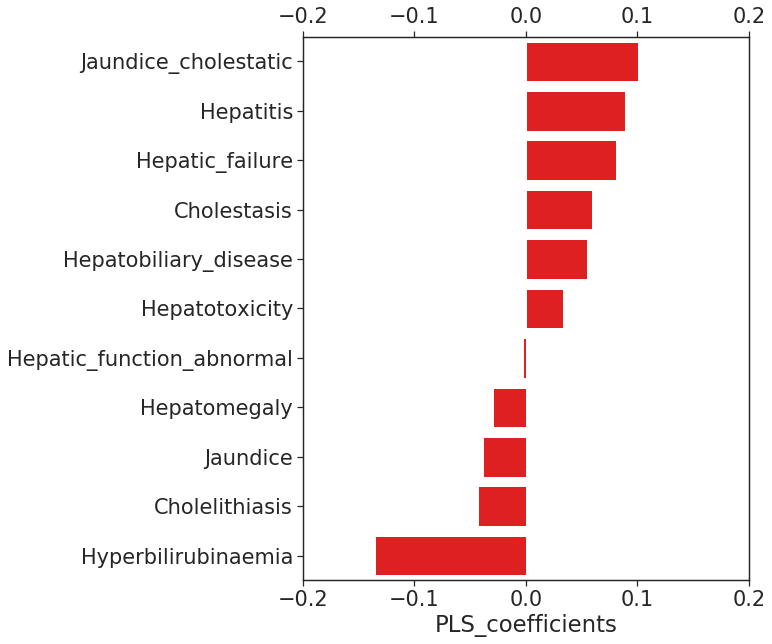

In [41]:
colorcol = 'significance'
testname = 'mostdilirank'
mybarplot(pls_mostdilirank_df, colorcol, testname)

## 4.4. Pfizer

In [42]:
confsig = [0.15]
testname = 'pfizer'
createDir(os.getcwd(), 'pls_coef_pickles')
for cfs in confsig:
    pred = pd.read_csv('predictions_no_optimization_'+str(cfs)+'/predictions_'+testname+'_'+str(cfs)+'.tsv', sep='\t')
    res = pd.read_csv('predictions_no_optimization_'+str(cfs)+'/results_'+testname+'_'+str(cfs)+'.tsv', sep='\t')
    pred.drop(columns = ['DILI', 'parent_nonstd_inkey'], inplace = True)
    plsdf = getloadings_pls_plot(pred, res, testname, sourcelabel=None)
    plsdf['significance'] = cfs
    plsdf.to_pickle('pls_coef_pickles/pls_'+testname+'_'+str(cfs)+'.pkl')

pls_coef_pickles already exists


In [43]:
pls_pfizer_df = pd.read_pickle('pls_coef_pickles/pls_pfizer_0.15.pkl')
pls_pfizer_df.head(2)

,coef,endpoint,source,significance
0,0.063664,Jaundice,pfizer,0.15
1,0.048020,Hepatitis,pfizer,0.15


figures already exists


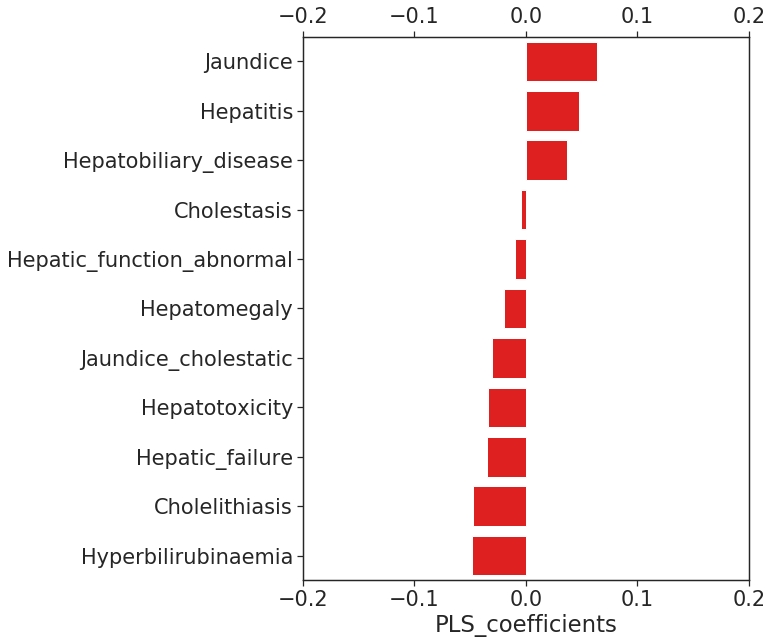

In [44]:
colorcol = 'significance'
testname = 'pfizer'
mybarplot(pls_pfizer_df, colorcol, testname)

## 4.5. Obrien

In [45]:
confsig = [0.15]
testname = 'obrien'
createDir(os.getcwd(), 'pls_coef_pickles')
for cfs in confsig:
    pred = pd.read_csv('predictions_no_optimization_'+str(cfs)+'/predictions_'+testname+'_'+str(cfs)+'.tsv', sep='\t')
    res = pd.read_csv('predictions_no_optimization_'+str(cfs)+'/results_'+testname+'_'+str(cfs)+'.tsv', sep='\t')
    pred.drop(columns = ['DILI', 'parent_nonstd_inkey'], inplace = True)
    plsdf = getloadings_pls_plot(pred, res, testname, sourcelabel=None)
    plsdf['significance'] = cfs
    plsdf.to_pickle('pls_coef_pickles/pls_'+testname+'_'+str(cfs)+'.pkl')

pls_coef_pickles already exists


In [46]:
pls_obrien_df = pd.read_pickle('pls_coef_pickles/pls_obrien_0.15.pkl')
pls_obrien_df

,coef,endpoint,source,significance
0,0.160508,Hepatitis,obrien,0.15
1,0.073670,Jaundice,obrien,0.15
2,0.059188,Hepatobiliary_disease,obrien,0.15
3,0.049213,Jaundice_cholestatic,obrien,0.15
4,-0.071475,Hepatic_function_abnormal,obrien,0.15
5,-0.079484,Hepatotoxicity,obrien,0.15
6,-0.081420,Cholestasis,obrien,0.15
7,-0.099909,Hepatic_failure,obrien,0.15
8,-0.118336,Hyperbilirubinaemia,obrien,0.15
9,-0.128404,Hepatomegaly,obrien,0.15


figures already exists


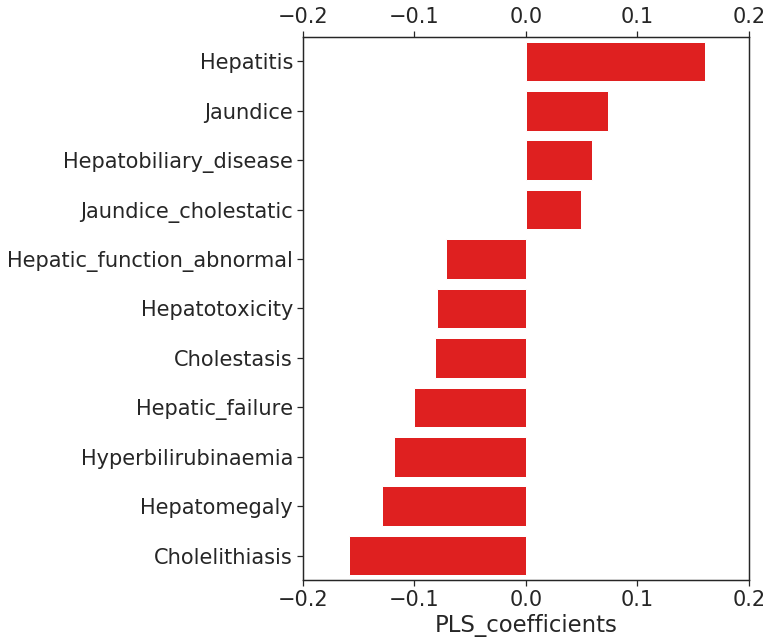

In [47]:
colorcol = 'significance'
testname = 'obrien'
mybarplot(pls_obrien_df, colorcol, testname)

## 4.6. Mulliner

In [48]:
confsig = [0.15]
testname = 'mulliner'
createDir(os.getcwd(), 'pls_coef_pickles')
for cfs in confsig:
    pred = pd.read_csv('predictions_no_optimization_'+str(cfs)+'/predictions_'+testname+'_'+str(cfs)+'.tsv', sep='\t')
    res = pd.read_csv('predictions_no_optimization_'+str(cfs)+'/results_'+testname+'_'+str(cfs)+'.tsv', sep='\t')
    pred.drop(columns = ['DILI', 'parent_nonstd_inkey'], inplace = True)
    plsdf = getloadings_pls_plot(pred, res, testname, sourcelabel=None)
    plsdf['significance'] = cfs
    plsdf.to_pickle('pls_coef_pickles/pls_'+testname+'_'+str(cfs)+'.pkl')

pls_coef_pickles already exists


In [49]:
pls_mulliner_df = pd.read_pickle('pls_coef_pickles/pls_mulliner_0.15.pkl')
pls_mulliner_df.head(2)

,coef,endpoint,source,significance
0,0.068674,Jaundice,mulliner,0.15
1,0.045015,Jaundice_cholestatic,mulliner,0.15


figures already exists


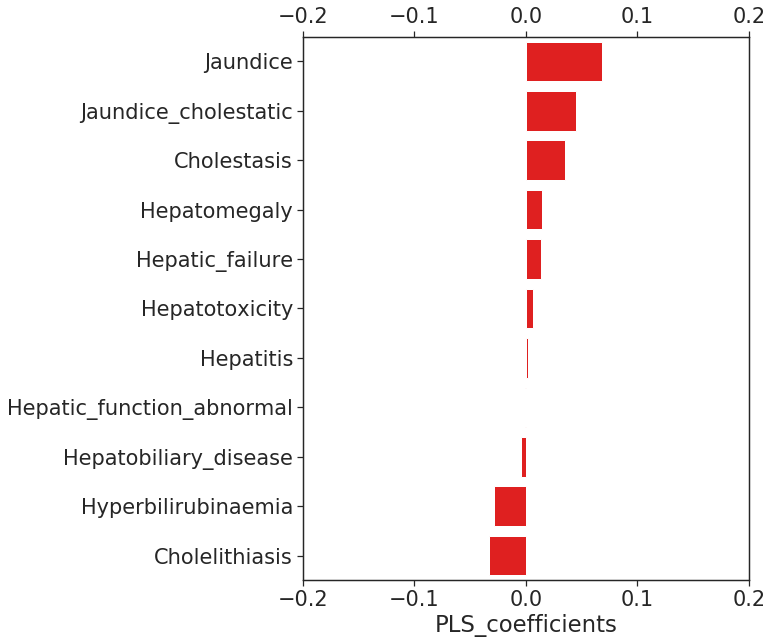

In [50]:
colorcol = 'significance'
testname = 'mulliner'
mybarplot(pls_mulliner_df, colorcol, testname)

## 4.7. Drugbank plus others

In [51]:
confsig = [0.15]
testname = 'drugbank'
createDir(os.getcwd(), 'pls_coef_pickles')
for cfs in confsig:
    pred = pd.read_csv('predictions_no_optimization_'+str(cfs)+'/predictions_'+testname+'_'+str(cfs)+'.tsv', sep='\t')
    res = pd.read_csv('predictions_no_optimization_'+str(cfs)+'/results_'+testname+'_'+str(cfs)+'.tsv', sep='\t')
    pred.drop(columns = ['DILI', 'parent_nonstd_inkey'], inplace = True)
    plsdf = getloadings_pls_plot(pred, res, testname, sourcelabel=None)
    plsdf['significance'] = cfs
    plsdf.to_pickle('pls_coef_pickles/pls_'+testname+'_'+str(cfs)+'.pkl')

pls_coef_pickles already exists


In [52]:
pls_drugbank_df = pd.read_pickle('pls_coef_pickles/pls_drugbank_0.15.pkl')
pls_drugbank_df

,coef,endpoint,source,significance
0,0.042131,Cholestasis,drugbank,0.15
1,0.027672,Hepatic_failure,drugbank,0.15
2,0.016093,Jaundice,drugbank,0.15
3,0.014124,Hepatitis,drugbank,0.15
4,0.013781,Hepatotoxicity,drugbank,0.15
5,0.011926,Jaundice_cholestatic,drugbank,0.15
6,0.009866,Cholelithiasis,drugbank,0.15
7,0.005527,Hepatobiliary_disease,drugbank,0.15
8,0.004712,Hepatic_function_abnormal,drugbank,0.15
9,-0.006377,Hyperbilirubinaemia,drugbank,0.15


figures already exists


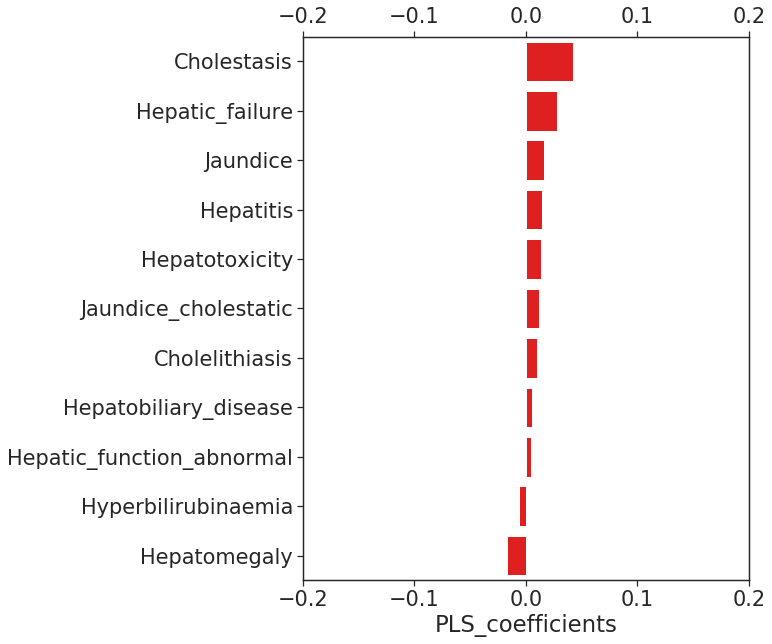

In [53]:
colorcol = 'significance'
testname = 'drugbank'
mybarplot(pls_drugbank_df, colorcol, testname)

## 4.7. Comparision PLS coefficients among all Sources: ALL, LTKB, PFIZER and OBRIEN

In [54]:
# pls_lessdilirank_df = pd.read_pickle('pls_coef_pickles/pls_lessdilirank.pkl')
# pls_mostdilirank_df = pd.read_pickle('pls_coef_pickles/pls_mostdilirank.pkl')
# pls_pfizer_df = pd.read_pickle('pls_coef_pickles/pls_pfizer.pkl')
# pls_obrien_df = pd.read_pickle('pls_coef_pickles/pls_obrien.pkl')
# pls_mul_df = pd.read_pickle('pls_coef_pickles/pls_mulliner.pkl')
# pls_drugbank_df = pd.read_pickle('pls_coef_pickles/pls_drugbank.pkl')

In [55]:
comparisondf = pd.concat([pls_mostdilirank_df, pls_pfizer_df,
                          pls_obrien_df, pls_mulliner_df], axis=0)
comparisondf.to_csv('pls_coef_pickles/pls_coefficients_AEs_predictions_combination.tsv', sep='\t', index=False)

In [56]:
def myfactorplot(df, colorcol, testname):

    mypal = ["#e74c3c", '#17becf', '#ff7f0e','#2ca02c',"#95a5a6",'#9467bd','#c7c7c7', '#ffff33',"#3498db"]
    sns.set_palette(mypal)
    myplot = sns.set(font_scale=2.1, font='Calibri', palette='bright')
    sns.set_palette(mypal)
    myplot = sns.set_style('ticks')
    myplot = sns.factorplot(y='endpoint', x='coef', hue=colorcol,
                            data=df, kind='bar', size=15, aspect=1)
    myplot.set_axis_labels(y_var='', x_var='PLS_coefficients')
    myplot.set(xlim = (np.min(df.coef)+(-0.1), np.max(df.coef)+(0.1)))
    myplot.set(xlim=(-0.20,0.20))
    plt.twiny()
#     plt.xlim(np.min(df.coef)+(-0.1), np.max(df.coef)+(+0.1))
#     plt.axis('off')
    plt.xlim(-0.20,0.20)
    createDir(os.getcwd(),'figures')
    myplot.fig.savefig("figures/PLS_coef_AEs_importance"+testname+".png", bbox_inches="tight")

figures already exists


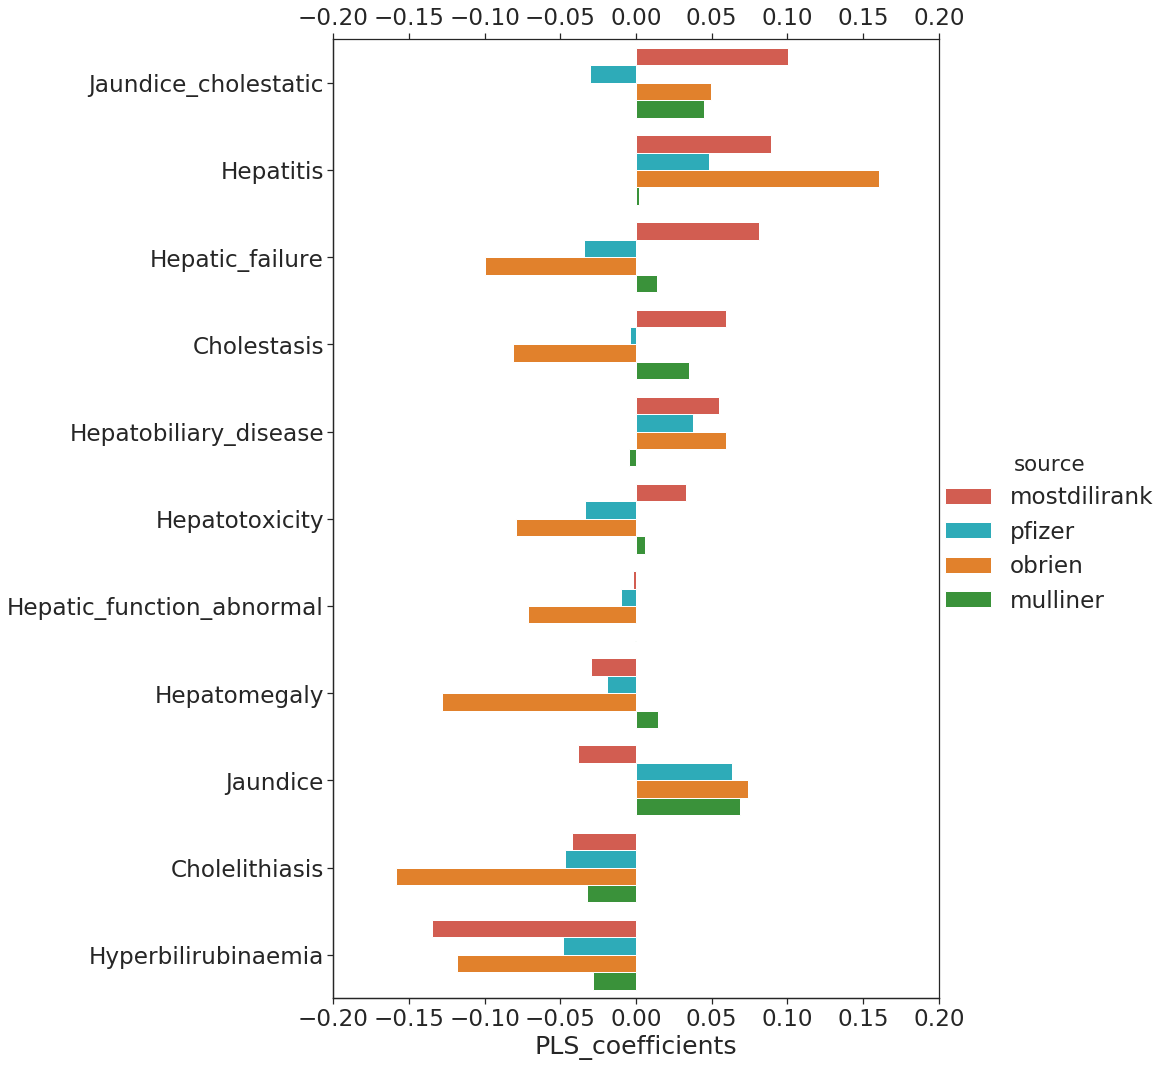

In [57]:
colorcol = 'source'
testname = 'comparison'
myfactorplot(comparisondf, colorcol, testname)

### Coefficients barplot explanation

This plot shows that Hepatitis, Jaundice cholestatic, Cholestatis and Jaundice are the most representative endpoints, saying that if one of this appears in a compound, that one is hepatotoxic. On the other hand, if we have a look at Cholelithiasis or hyperbilirubinaemia endpoints, it is showing us that when these endpoints appears, the compound is NOT hepatotoxic.

# 5.  Combining Predictions: 
- This section we will get predictions combination between models  in a pyramid combination way:
    - predict with model 0 and 1, get consensus
    - predict with model 0, 1 and 2, get consensus
    - ...
    - predict with model 0, 1, 2, 3, 4, 5, 6, 7, 8 and 9, get consensus
    
- where 0 is the best model sorted by best pls_coefficients and 9 the worst one.

- Individual predictions

## 5.1. Prediction  and consensus functions

In [67]:
# Get consensus prediction. Here the rules to class assignment. 
def get_consensus(frame):
    '''
    Add doc string explanation
    '''
    consensus = []
    for index, row in frame.iterrows():
        val = 0
#         Get number of positive, negative and out of AD
#         predictions
        counts = row.value_counts().to_dict()
        if 1 in counts.keys():
            val = 1
            try:
                if counts[0] > counts[1]:
                    val = 0
            except:
                pass
        else:
            if 0 in counts.keys():
                val = 0
            else:
                val = 2

        consensus.append(val)
    return consensus
            

In [68]:
# Get consensus prediction. Here the rules to class assignment. 
def get_consensus_general(frame):
    '''
    Add doc string explanation
    '''
    consensus = []
    for index, row in frame.iterrows():
        val = 0
#         Get number of positive, negative and out of AD
#         predictions
        counts = row.value_counts().to_dict()
        if 1 in counts.keys():
            val = 1
        else:
            if 0 in counts.keys():
                val = 0
            else:
                val = 2

        consensus.append(val)
    return consensus
            

In [76]:
def run_optimization_prediction(modeldict, idx_model, preddf, testname, testDILIcolumn):
    '''
    Example:
        testname = 'pfizer'
        idx_model = '0'
        modeldict = pfizerdict
        sdfile = pfizersdf
        testDF = pfizer_val.copy()
        testDILIcolumn = 'DILI positive/negative as observed'
        TN, FP, FN, TP, sens, spec, mcc, tmol, molsinAD, molsoutAD,  pAD = run_ext_prediction(model_list,pfizersdf, testname, testDF, testDILIcolumn)
    '''
    ##### Running predictions:
    
    # Get prediction of a set of compounds for a given list of models. Endpoint and version column names
    # needed. Returns a dataframe with predictions for each endpoint as columns
    models = modeldict[idx_model]
    print (models)

    ##### Quality predictions:
    pred = preddf.copy()
    pred = pred[models]
    ## removing first column containing inchi keys
#     pred.drop(columns = ['parent_nonstd_inkey'], inplace = True)

    ## Running consensus predictions function
    consensus_mv = get_consensus(pred)
    consensus_g = get_consensus_general(pred)

    # Create a new dataframe with consensus predictions and experimental values
    results = pd.DataFrame()
    results[testname] = pd.to_numeric(preddf[testDILIcolumn])
    results['pred_mv'] = consensus_mv
    results['pred_g'] = consensus_g
    createDir(os.getcwd(), testname+'_results_optimization/')
    results.to_csv(testname+'_results_optimization/results_'+testname+'_'+idx_model+'.tsv', sep='\t', index=None)
    print('Consensus predictions molecules:',len(results))

    # Creating a new dataframe discarding compounds out of the Applicability Domain (AD)
    ad_in = results[results['pred_mv'] != 2]
   
    print('Consensus predictions molecules inside applicability domain:',len(ad_in))
    molsoutAD = len(results) - len(ad_in)
    print('Molecules out of AD:', molsoutAD)
    
    ## calculating percentage inside of AD molecules
    pAD = (len(ad_in)/len(results))*100
    print('Percentage molecules in of AD:', pAD)

    # Getting Quality performance parameters for qualitative endpoints predictions.
    from sklearn.metrics import matthews_corrcoef as mcc
    matthew = mcc(ad_in['pred_mv'].tolist(), ad_in[testname].tolist())
    TN, FP, FN, TP = cm(ad_in['pred_mv'].tolist(), ad_in[testname].tolist()).ravel()
    sensitivity = (TP / (TP + FN))
    specificity = (TN / (TN + FP))
    print('MCC_'+idx_model+': ', matthew)
    print('Sens_'+idx_model+': ', sensitivity)
    print('Spec_'+idx_model+': ', specificity)
    
    quality_params_mv = [TP, FP, TN, FN, sensitivity, specificity,
                         matthew, len(results), len(ad_in), molsoutAD,  pAD]
    
    matthew = mcc(ad_in['pred_g'].tolist(), ad_in[testname].tolist())
    TN, FP, FN, TP = cm(ad_in['pred_g'].tolist(), ad_in[testname].tolist()).ravel()
    sensitivity = (TP / (TP + FN))
    specificity = (TN / (TN + FP))
    print('MCC_'+idx_model+': ', matthew)
    print('Sens_'+idx_model+': ', sensitivity)
    print('Spec_'+idx_model+': ', specificity)
    
    quality_params_g = [TP, FP, TN, FN, sensitivity, specificity,
                        matthew, len(results), len(ad_in), molsoutAD,  pAD]
    
    return (quality_params_mv, quality_params_g)

In [77]:
def get_pyramid_combination(df, colname):
    modeldict={}
    for row in range(len(df)):
        modellist = []
        for column in range(row+1):
            modellist.append(df[colname][column])
        modeldict[str(row)] = modellist

    return (modeldict)

In [71]:
# def get_3Dscatterplot(df, consensus, testname):
#     import matplotlib.pyplot as plt
#     import seaborn as sns
#     import numpy as np
#     import pandas as pd
#     from  matplotlib.lines import Line2D
    
# #     font = {'family' : 'normal',
# #             'weight' : 'normal',
# #             'size'   : 16}

# #     plt.rc('font', **font)
#     sns.set(font_scale=1.8, font='Calibri', palette='bright')
#     sns.set_style('ticks')
#     #width = .35 # width of a bar
#     m1_t = pd.DataFrame({
#      'MCC' :  list(df['mcc_'+consensus].values),
#      'Cover': list(df['percentage_AD_'+consensus].values/100),})
#     x = reversed(list(df['mcc_'+consensus].values))
#     y = reversed([i for i in range(len(df))])
#     y2 = ([i for i in range(len(df))])
#     x = list(x)
#     y = list(y)
#     plt.figure(figsize=(8,10))
#     plt.barh(y2, width=x, label='MCC', color='lightblue')
#     plt.xlim(0,1.05)
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.60))
#     axes2 = plt.twiny()
#     axes2.set_yticklabels(labels=reversed(list(df.endpoint.values)))
#     axes2.set_yticks(np.arange(len(df.endpoint.values)))
#     axes2.plot(m1_t['Cover'], y, color='r', label='Sine')
#     plt.xlim(0,1.05)
#     red_line = Line2D([], [], color='red', label='Coverage')
#     plt.legend(handles=[red_line], loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.savefig('figures/MCC_coverage_'+testname+'.png',  bbox_inches="tight")

In [72]:
def mybarplot(df, testname, colmcc, colcoverage, rule):
    from  matplotlib.lines import Line2D
    mypal = ["#e74c3c", '#17becf', '#ff7f0e','#2ca02c',"#95a5a6",'#9467bd','#c7c7c7', '#ffff33',"#3498db"]
    sns.set_palette(mypal)
    plt.figure(figsize=(8,10))
    myplot = sns.set(font_scale=1.9, font='Calibri', palette='bright')
    sns.set_palette(mypal)
    myplot = sns.set_style('ticks')
    myplot = sns.barplot(y='endpoint', x=colmcc+'_'+rule, color='lightblue', data=df)
    myplot.set(xlim=(0,1.05))
    plt.xlabel('MCC')
    plt.ylabel('')
    plt.twiny()
    df1 = df.copy()
    df1[colcoverage+'_'+rule] = [x/100 for x in df1[colcoverage+'_'+rule]]
    sns.lineplot(x=df1[colcoverage+'_'+rule], y=df1['model_combination'], color='r',
                 legend='full', estimator=None)
    plt.xlim(0,1.05)
    plt.xlabel('')
    red_line = Line2D([], [], color='red', label='Coverage')
    plt.legend(handles=[red_line],loc='center left', bbox_to_anchor=(1.05, 0.5)) ## outside
#     plt.legend(handles=[red_line]) ## inside
    createDir(os.getcwd(),'figures')
    plt.savefig('figures/MCC_coverage_'+testname+'_'+rule+'.png',  bbox_inches="tight")

## 5.4. mostDILIrank Dataset:

In [78]:
mostDILIrank_dict = get_pyramid_combination(pls_mostdilirank_df, 'endpoint')

In [79]:
preddf = pd.read_csv('predictions_no_optimization_0.15/predictions_mostdilirank_0.15.tsv', sep='\t')
preddf.head(2)

,parent_nonstd_inkey,Jaundice_cholestatic,Hyperbilirubinaemia,Hepatic_failure,Cholelithiasis,Cholestasis,Hepatitis,Jaundice,Hepatobiliary_disease,Hepatomegaly,Hepatotoxicity,Hepatic_function_abnormal,DILI
0,QHOUDEZPFKDYIG-GUGYNKHWNA-M,2,1,2,2,2,1,1,0,1,1,1,1.0
1,ONNOFKFOZAJDHT-MPIMZMORNA-N,1,0,2,2,2,2,2,2,2,0,2,1.0


In [80]:
# preddf = pd.read_csv('predictions_no_optimization_0.15/predictions_mostdilirank_0.15.tsv', sep='\t')
testname = 'mostdilirank'
testDILIcolumn = 'DILI'

mostdilirank_performance_DF = pd.DataFrame([])

for i in range(len(mostDILIrank_dict)):
    quality_params_mv, quality_params_g = run_optimization_prediction(mostDILIrank_dict, str(i), preddf,
                                                                      testname, testDILIcolumn)

    quality_params_mv_DF = pd.DataFrame(quality_params_mv)
    quality_params_mv_DF = quality_params_mv_DF.T
    quality_params_g_DF = pd.DataFrame(quality_params_g)
    quality_params_g_DF = quality_params_g_DF.T
    models = mostDILIrank_dict[str(i)]
    models = str(models).lstrip('[').rstrip(']')
    quality_params_mv_DF['models_used_mv'] = models
    quality_params_g_DF['models_used_g'] = models

    qualdf = pd.concat([quality_params_mv_DF, quality_params_g_DF], axis = 1)
    mostdilirank_performance_DF = pd.concat([mostdilirank_performance_DF, qualdf],
                                             ignore_index=True, axis=0)

mostdilirank_performance_DF.columns = ['TP_mv', 'FP_mv', 'TN_mv', 'FN_mv', 'sens_mv', 'spec_mv',
                                       'mcc_mv', 'total_mols_mv', 'molsinAD_mv', 'molsoutAD_mv',
                                       'percentage_AD_mv', 'models_used_mv',
                                       'TP_g', 'FP_g', 'TN_g', 'FN_g', 'sens_g', 'spec_g',
                                       'mcc_g', 'total_mols_g', 'molsinAD_g', 'molsoutAD_g',
                                       'percentage_AD_g', 'models_used_g']

mostdilirank_performance_DF = mostdilirank_performance_DF[['models_used_mv', 'TP_mv', 'FP_mv', 'TN_mv',
                                                           'FN_mv', 'sens_mv', 'spec_mv',
                                                           'mcc_mv', 'total_mols_mv', 'molsinAD_mv',
                                                           'molsoutAD_mv', 'percentage_AD_mv', 
                                                           'models_used_g',
                                                           'TP_g', 'FP_g', 'TN_g', 'FN_g', 'sens_g',
                                                           'spec_g', 'mcc_g', 'total_mols_g', 'molsinAD_g',
                                                           'molsoutAD_g', 'percentage_AD_g']]


mostdilirank_performance_DF['source'] = 'mostdilirank'
mostdilirank_performance_DF.index = mostdilirank_performance_DF.index.set_names(['model_combination'])
mostdilirank_performance_DF.reset_index(inplace=True)
mostdilirank_performance_DF['endpoint'] = pls_mostdilirank_df['endpoint']
mostdilirank_performance_DF.to_pickle(testname+'_results_optimization/mostdilirank_performance_optimization_prediction.pkl')
mostdilirank_performance_DF.to_csv(testname+'_results_optimization/mostdilirank_performance.csv', sep='\t', index=False)

['Jaundice_cholestatic']
mostdilirank_results_optimization/ is created
Consensus predictions molecules: 177
Consensus predictions molecules inside applicability domain: 75
Molecules out of AD: 102
Percentage molecules in of AD: 42.3728813559322
MCC_0:  0.5463235193135126
Sens_0:  0.8666666666666667
Spec_0:  0.7833333333333333
MCC_0:  0.5463235193135126
Sens_0:  0.8666666666666667
Spec_0:  0.7833333333333333
['Jaundice_cholestatic', 'Hepatitis']
mostdilirank_results_optimization/ already exists
Consensus predictions molecules: 177
Consensus predictions molecules inside applicability domain: 113
Molecules out of AD: 64
Percentage molecules in of AD: 63.84180790960452
MCC_1:  0.5592168941650983
Sens_1:  0.8125
Spec_1:  0.7901234567901234
MCC_1:  0.5592168941650983
Sens_1:  0.8125
Spec_1:  0.7901234567901234
['Jaundice_cholestatic', 'Hepatitis', 'Hepatic_failure']
mostdilirank_results_optimization/ already exists
Consensus predictions molecules: 177
Consensus predictions molecules inside a

In [81]:
mostdilirank_performance_DF.head(1)

,model_combination,models_used_mv,TP_mv,FP_mv,TN_mv,FN_mv,sens_mv,spec_mv,mcc_mv,total_mols_mv,molsinAD_mv,molsoutAD_mv,percentage_AD_mv,models_used_g,TP_g,FP_g,TN_g,FN_g,sens_g,spec_g,mcc_g,total_mols_g,molsinAD_g,molsoutAD_g,percentage_AD_g,source,endpoint
0,0,'Jaundice_cholestatic',13.0,13.0,47.0,2.0,0.866667,0.783333,0.546324,177.0,75.0,102.0,42.372881,'Jaundice_cholestatic',13.0,13.0,47.0,2.0,0.866667,0.783333,0.546324,177.0,75.0,102.0,42.372881,mostdilirank,Jaundice_cholestatic


figures already exists


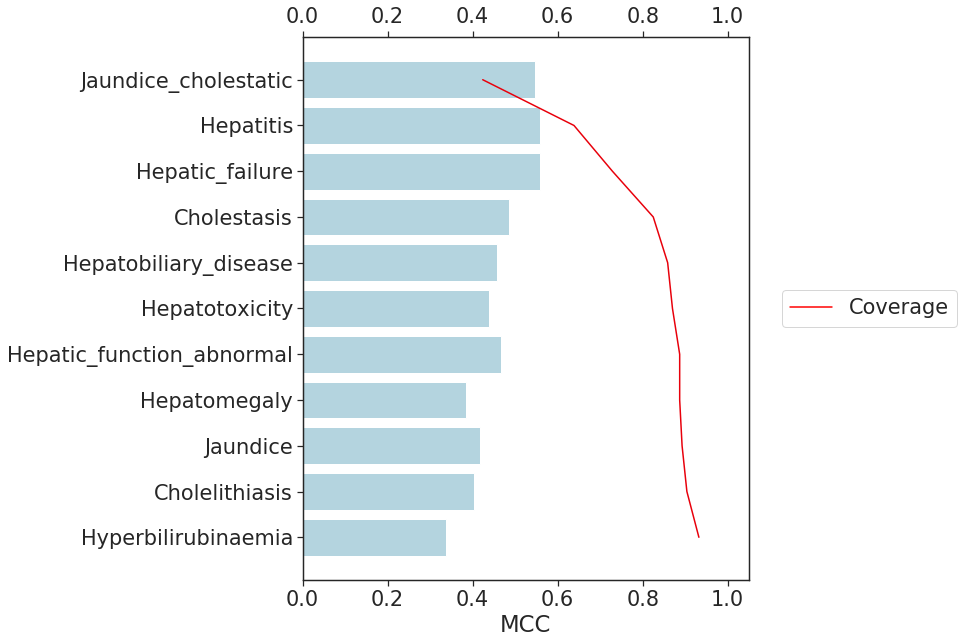

In [82]:
testname = 'mostdilirank'
colmcc = 'mcc'
rule = 'mv'
colcoverage = 'percentage_AD'
mybarplot(mostdilirank_performance_DF,testname, colmcc, colcoverage, rule)

figures already exists


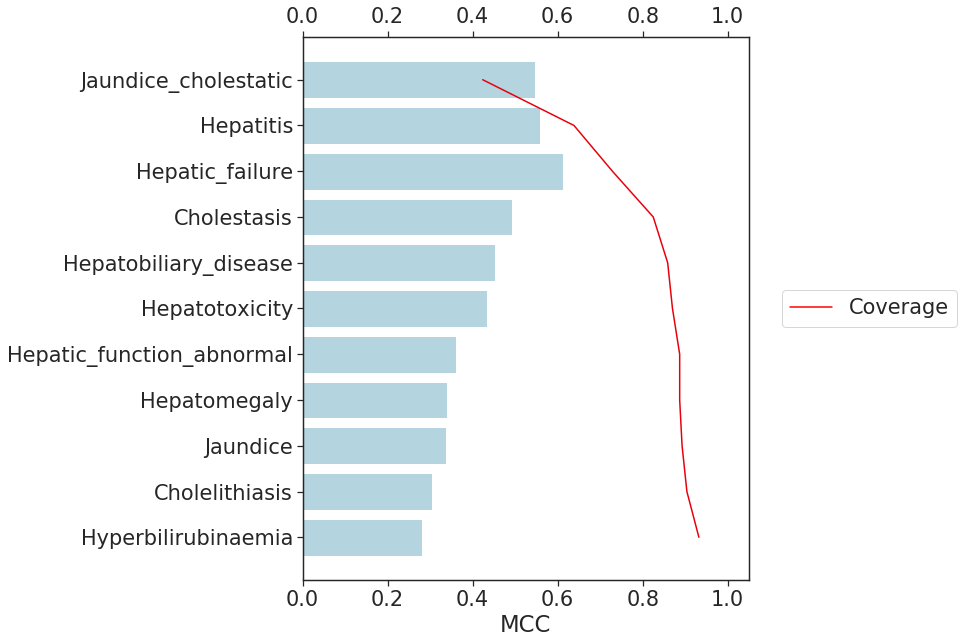

In [83]:
testname = 'mostdilirank'
colmcc = 'mcc'
rule = 'g'
colcoverage = 'percentage_AD'
mybarplot(mostdilirank_performance_DF,testname, colmcc, colcoverage, rule)

#### External Validation discussion:
As can be seen from the qualitative results, the external validation performed excellent, giving as sensitivity (sens) X, specificity (spec) X and Matthews correlation coefficient (MCC) X.

## 5.5. PfizerDataset:

In [84]:
pfizer_dict = get_pyramid_combination(pls_pfizer_df, 'endpoint')

In [85]:
preddf = pd.read_csv('predictions_no_optimization_0.15/predictions_pfizer_0.15.tsv', sep='\t')
preddf.head(2)

,parent_nonstd_inkey,Jaundice_cholestatic,Hyperbilirubinaemia,Hepatic_failure,Cholelithiasis,Cholestasis,Hepatitis,Jaundice,Hepatobiliary_disease,Hepatomegaly,Hepatotoxicity,Hepatic_function_abnormal,DILI
0,SHGAZHPCJJPHSC-CQERCXARNA-M,2,0,2,2,2,1,2,0,2,1,0,1
1,PPQNQXQZIWHJRB-UHFFFAOYNA-N,2,2,1,2,1,2,2,2,0,2,2,1


In [86]:
testname = 'pfizer'
testDILIcolumn = 'DILI'

pfizer_performance_DF = pd.DataFrame([])
for i in range(len(pfizer_dict)):
    quality_params_mv, quality_params_g = run_optimization_prediction(pfizer_dict, str(i), preddf,
                                                                      testname, testDILIcolumn, )
    quality_params_mv_DF = pd.DataFrame(quality_params_mv)
    quality_params_mv_DF = quality_params_mv_DF.T
    quality_params_g_DF = pd.DataFrame(quality_params_g)
    quality_params_g_DF = quality_params_g_DF.T
    models = pfizer_dict[str(i)]
    models = str(models).lstrip('[').rstrip(']')
    quality_params_mv_DF['models_used_mv'] = models
    quality_params_g_DF['models_used_g'] = models

    qualdf = pd.concat([quality_params_mv_DF, quality_params_g_DF], axis = 1)
    pfizer_performance_DF = pd.concat([pfizer_performance_DF, qualdf],
                                             ignore_index=True, axis=0)

pfizer_performance_DF.columns = ['TP_mv', 'FP_mv', 'TN_mv', 'FN_mv', 'sens_mv', 'spec_mv',
                                       'mcc_mv', 'total_mols_mv', 'molsinAD_mv', 'molsoutAD_mv',
                                       'percentage_AD_mv', 'models_used_mv',
                                       'TP_g', 'FP_g', 'TN_g', 'FN_g', 'sens_g', 'spec_g',
                                       'mcc_g', 'total_mols_g', 'molsinAD_g', 'molsoutAD_g',
                                       'percentage_AD_g', 'models_used_g']

pfizer_performance_DF = pfizer_performance_DF[['models_used_mv', 'TP_mv', 'FP_mv', 'TN_mv',
                                                           'FN_mv', 'sens_mv', 'spec_mv',
                                                           'mcc_mv', 'total_mols_mv', 'molsinAD_mv',
                                                           'molsoutAD_mv', 'percentage_AD_mv', 
                                                           'models_used_g',
                                                           'TP_g', 'FP_g', 'TN_g', 'FN_g', 'sens_g',
                                                           'spec_g', 'mcc_g', 'total_mols_g', 'molsinAD_g',
                                                           'molsoutAD_g', 'percentage_AD_g']]


pfizer_performance_DF['source'] = 'pfizer'
pfizer_performance_DF.index = pfizer_performance_DF.index.set_names(['model_combination'])
pfizer_performance_DF.reset_index(inplace=True)
pfizer_performance_DF['endpoint'] = pls_pfizer_df['endpoint']
pfizer_performance_DF.to_pickle(testname+'_results_optimization/pfizer_performance_optimization_prediction.pkl')
pfizer_performance_DF.to_csv(testname+'_results_optimization/pfizer_performance.csv', sep='\t', index=False)

['Jaundice']
pfizer_results_optimization/ is created
Consensus predictions molecules: 147
Consensus predictions molecules inside applicability domain: 65
Molecules out of AD: 82
Percentage molecules in of AD: 44.21768707482993
MCC_0:  0.34020690871988585
Sens_0:  0.85
Spec_0:  0.5111111111111111
MCC_0:  0.34020690871988585
Sens_0:  0.85
Spec_0:  0.5111111111111111
['Jaundice', 'Hepatitis']
pfizer_results_optimization/ already exists
Consensus predictions molecules: 147
Consensus predictions molecules inside applicability domain: 83
Molecules out of AD: 64
Percentage molecules in of AD: 56.4625850340136
MCC_1:  0.3632842248698088
Sens_1:  0.8055555555555556
Spec_1:  0.5531914893617021
MCC_1:  0.3632842248698088
Sens_1:  0.8055555555555556
Spec_1:  0.5531914893617021
['Jaundice', 'Hepatitis', 'Hepatobiliary_disease']
pfizer_results_optimization/ already exists
Consensus predictions molecules: 147
Consensus predictions molecules inside applicability domain: 95
Molecules out of AD: 52
Perc

In [87]:
pfizer_performance_DF.head(1)

,model_combination,models_used_mv,TP_mv,FP_mv,TN_mv,FN_mv,sens_mv,spec_mv,mcc_mv,total_mols_mv,molsinAD_mv,molsoutAD_mv,percentage_AD_mv,models_used_g,TP_g,FP_g,TN_g,FN_g,sens_g,spec_g,mcc_g,total_mols_g,molsinAD_g,molsoutAD_g,percentage_AD_g,source,endpoint
0,0,'Jaundice',17.0,22.0,23.0,3.0,0.85,0.511111,0.340207,147.0,65.0,82.0,44.217687,'Jaundice',17.0,22.0,23.0,3.0,0.85,0.511111,0.340207,147.0,65.0,82.0,44.217687,pfizer,Jaundice


figures already exists


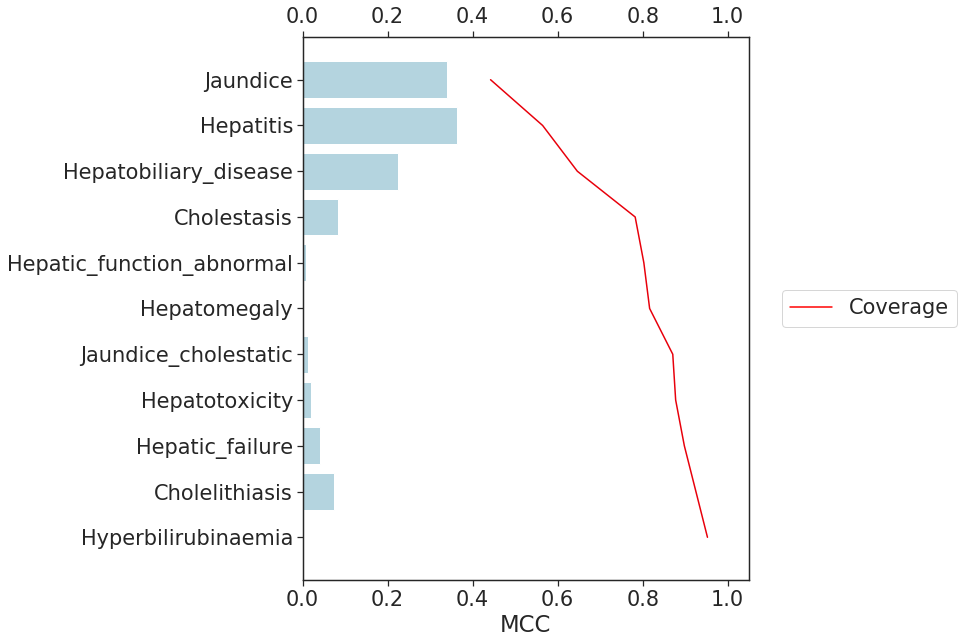

In [88]:
testname = 'pfizer'
colmcc = 'mcc'
rule = 'mv'
colcoverage = 'percentage_AD'
mybarplot(pfizer_performance_DF,testname, colmcc, colcoverage, rule)

figures already exists


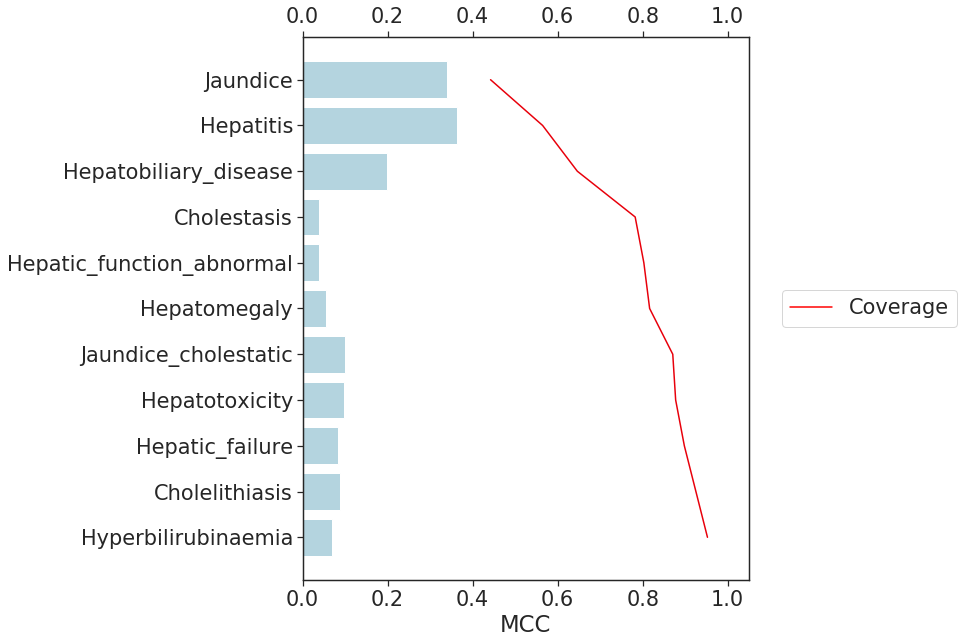

In [89]:
testname = 'pfizer'
colmcc = 'mcc'
rule = 'g'
colcoverage = 'percentage_AD'
mybarplot(pfizer_performance_DF,testname, colmcc, colcoverage, rule)

#### External Validation discussion:
As can be seen from the qualitative results, the external validation performed excellent, giving as sensitivity (sens) X, specificity (spec) X and Matthews correlation coefficient (MCC) X.

## 5.6. Obrien Dataset:

In [90]:
obrien_dict = get_pyramid_combination(pls_obrien_df, 'endpoint')

In [91]:
preddf = pd.read_csv('predictions_no_optimization_0.15/predictions_obrien_0.15.tsv', sep='\t')
preddf.head(2)

,parent_nonstd_inkey,Jaundice_cholestatic,Hyperbilirubinaemia,Hepatic_failure,Cholelithiasis,Cholestasis,Hepatitis,Jaundice,Hepatobiliary_disease,Hepatomegaly,Hepatotoxicity,Hepatic_function_abnormal,DILI
0,RZVAJINKPMORJF-BGGKNDAXNA-N,0,0,1,0,2,1,0,1,0,2,2,1.0
1,WUBBRNOQWQTFEX-GDBCZBPSNA-M,2,0,1,2,1,1,2,1,2,1,2,1.0


In [92]:
testname = 'obrien'
testDILIcolumn = 'DILI'

obrien_performance_DF = pd.DataFrame([])
for i in range(len(obrien_dict)):
    quality_params_mv, quality_params_g = run_optimization_prediction(obrien_dict, str(i), preddf,
                                                                      testname, testDILIcolumn)
    quality_params_mv_DF = pd.DataFrame(quality_params_mv)
    quality_params_mv_DF = quality_params_mv_DF.T
    quality_params_g_DF = pd.DataFrame(quality_params_g)
    quality_params_g_DF = quality_params_g_DF.T
    models = obrien_dict[str(i)]
    models = str(models).lstrip('[').rstrip(']')
    quality_params_mv_DF['models_used_mv'] = models
    quality_params_g_DF['models_used_g'] = models

    qualdf = pd.concat([quality_params_mv_DF, quality_params_g_DF], axis = 1)
    obrien_performance_DF = pd.concat([obrien_performance_DF, qualdf],
                                             ignore_index=True, axis=0)

obrien_performance_DF.columns = ['TP_mv', 'FP_mv', 'TN_mv', 'FN_mv', 'sens_mv', 'spec_mv',
                                       'mcc_mv', 'total_mols_mv', 'molsinAD_mv', 'molsoutAD_mv',
                                       'percentage_AD_mv', 'models_used_mv',
                                       'TP_g', 'FP_g', 'TN_g', 'FN_g', 'sens_g', 'spec_g',
                                       'mcc_g', 'total_mols_g', 'molsinAD_g', 'molsoutAD_g',
                                       'percentage_AD_g', 'models_used_g']

obrien_performance_DF = obrien_performance_DF[['models_used_mv', 'TP_mv', 'FP_mv', 'TN_mv',
                                                           'FN_mv', 'sens_mv', 'spec_mv',
                                                           'mcc_mv', 'total_mols_mv', 'molsinAD_mv',
                                                           'molsoutAD_mv', 'percentage_AD_mv', 
                                                           'models_used_g',
                                                           'TP_g', 'FP_g', 'TN_g', 'FN_g', 'sens_g',
                                                           'spec_g', 'mcc_g', 'total_mols_g', 'molsinAD_g',
                                                           'molsoutAD_g', 'percentage_AD_g']]


obrien_performance_DF['source'] = 'obrien'
obrien_performance_DF.index = obrien_performance_DF.index.set_names(['model_combination'])
obrien_performance_DF.reset_index(inplace=True)
obrien_performance_DF['endpoint'] = pls_obrien_df['endpoint']
obrien_performance_DF.to_pickle(testname+'_results_optimization/obrien_performance_optimization_prediction.pkl')
obrien_performance_DF.to_csv(testname+'_results_optimization/obrien_performance.csv', sep='\t', index=False)

['Hepatitis']
obrien_results_optimization/ is created
Consensus predictions molecules: 40
Consensus predictions molecules inside applicability domain: 18
Molecules out of AD: 22
Percentage molecules in of AD: 45.0
MCC_0:  0.6625413488689132
Sens_0:  0.9
Spec_0:  0.75
MCC_0:  0.6625413488689132
Sens_0:  0.9
Spec_0:  0.75
['Hepatitis', 'Jaundice']
obrien_results_optimization/ already exists
Consensus predictions molecules: 40
Consensus predictions molecules inside applicability domain: 28
Molecules out of AD: 12
Percentage molecules in of AD: 70.0
MCC_1:  0.4873877907780315
Sens_1:  0.9230769230769231
Spec_1:  0.5333333333333333
MCC_1:  0.4873877907780315
Sens_1:  0.9230769230769231
Spec_1:  0.5333333333333333
['Hepatitis', 'Jaundice', 'Hepatobiliary_disease']
obrien_results_optimization/ already exists
Consensus predictions molecules: 40
Consensus predictions molecules inside applicability domain: 31
Molecules out of AD: 9
Percentage molecules in of AD: 77.5
MCC_2:  0.3133397807202561
S

In [93]:
obrien_performance_DF.head(2)

,model_combination,models_used_mv,TP_mv,FP_mv,TN_mv,FN_mv,sens_mv,spec_mv,mcc_mv,total_mols_mv,molsinAD_mv,molsoutAD_mv,percentage_AD_mv,models_used_g,TP_g,FP_g,TN_g,FN_g,sens_g,spec_g,mcc_g,total_mols_g,molsinAD_g,molsoutAD_g,percentage_AD_g,source,endpoint
0,0,'Hepatitis',9.0,2.0,6.0,1.0,0.900000,0.750000,0.662541,40.0,18.0,22.0,45.0,'Hepatitis',9.0,2.0,6.0,1.0,0.900000,0.750000,0.662541,40.0,18.0,22.0,45.0,obrien,Hepatitis
1,1,"'Hepatitis', 'Jaundice'",12.0,7.0,8.0,1.0,0.923077,0.533333,0.487388,40.0,28.0,12.0,70.0,"'Hepatitis', 'Jaundice'",12.0,7.0,8.0,1.0,0.923077,0.533333,0.487388,40.0,28.0,12.0,70.0,obrien,Jaundice


figures already exists


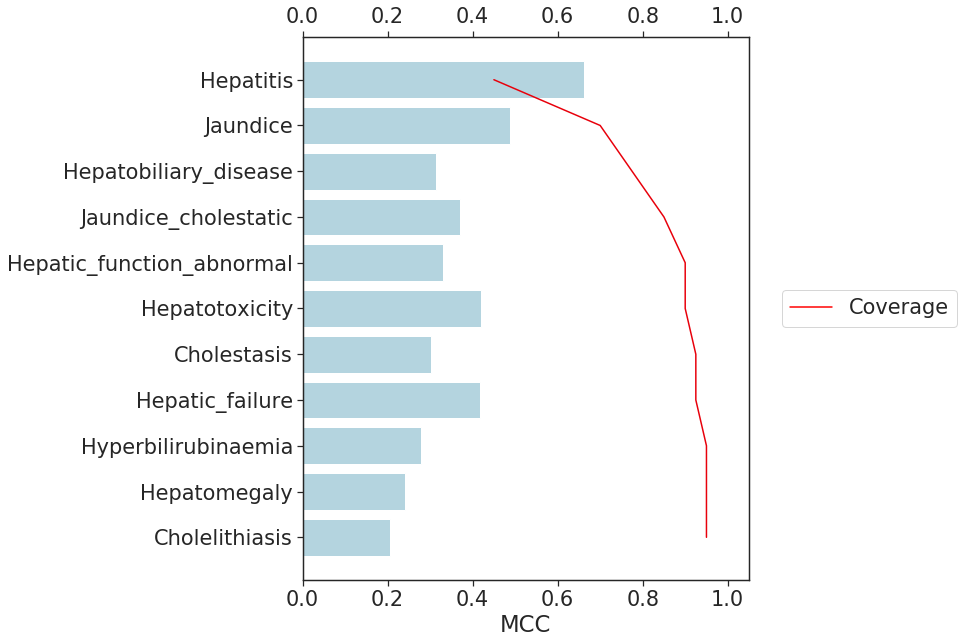

In [94]:
testname = 'obrien'
colmcc = 'mcc'
rule = 'mv'
colcoverage = 'percentage_AD'
mybarplot(obrien_performance_DF,testname, colmcc, colcoverage, rule)

figures already exists


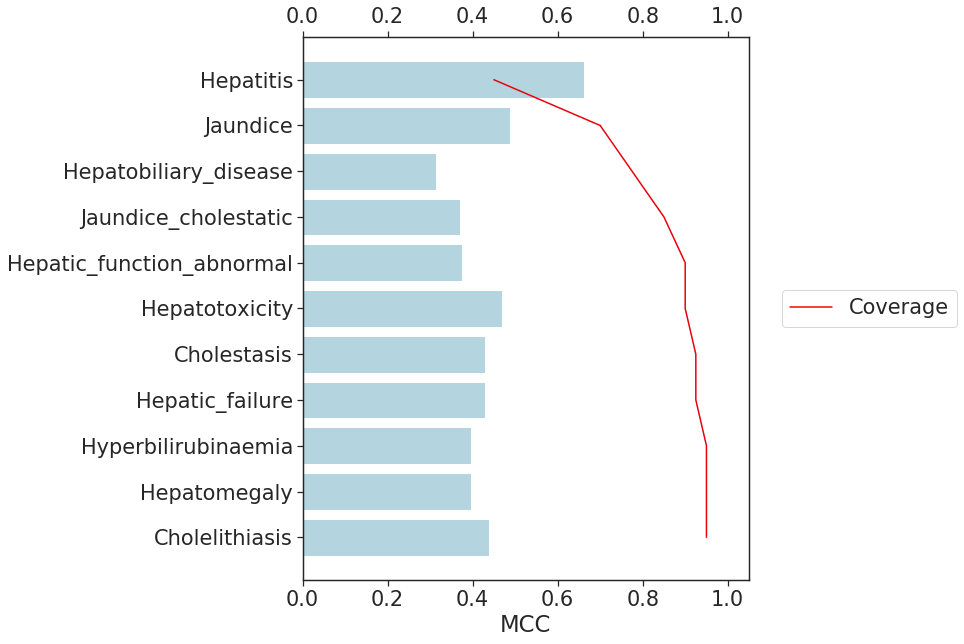

In [95]:
testname = 'obrien'
colmcc = 'mcc'
rule = 'g'
colcoverage = 'percentage_AD'
mybarplot(obrien_performance_DF,testname, colmcc, colcoverage, rule)

#### External Validation discussion:
As can be seen from the qualitative results, the external validation performed excellent, giving as sensitivity (sens) X, specificity (spec) X and Matthews correlation coefficient (MCC) X.

## 5.7. Mulliner Dataset:

In [96]:
mul_dict = get_pyramid_combination(pls_mulliner_df, 'endpoint')

In [97]:
preddf = pd.read_csv('predictions_no_optimization_0.15/predictions_mulliner_0.15.tsv', sep='\t')
preddf.head(2)

,parent_nonstd_inkey,Jaundice_cholestatic,Hyperbilirubinaemia,Hepatic_failure,Cholelithiasis,Cholestasis,Hepatitis,Jaundice,Hepatobiliary_disease,Hepatomegaly,Hepatotoxicity,Hepatic_function_abnormal,DILI
0,YENRTVJWRCAGEM-GJSJBMJMNA-M,0,1,2,2,2,2,2,2,2,2,2,1
1,RBTBFTRPCNLSDE-UHFFFAOYNA-N,2,2,2,2,2,2,1,2,0,2,2,1


In [98]:
testname = 'mulliner'
testDILIcolumn = 'DILI'

mulliner_performance_DF = pd.DataFrame([])
for i in range(len(mul_dict)):
    quality_params_mv, quality_params_g = run_optimization_prediction(mul_dict, str(i), preddf,
                                                                      testname, testDILIcolumn)
    quality_params_mv_DF = pd.DataFrame(quality_params_mv)
    quality_params_mv_DF = quality_params_mv_DF.T
    quality_params_g_DF = pd.DataFrame(quality_params_g)
    quality_params_g_DF = quality_params_g_DF.T
    models = mul_dict[str(i)]
    models = str(models).lstrip('[').rstrip(']')
    quality_params_mv_DF['models_used_mv'] = models
    quality_params_g_DF['models_used_g'] = models

    qualdf = pd.concat([quality_params_mv_DF, quality_params_g_DF], axis = 1)
    mulliner_performance_DF = pd.concat([mulliner_performance_DF, qualdf],
                                             ignore_index=True, axis=0)

mulliner_performance_DF.columns = ['TP_mv', 'FP_mv', 'TN_mv', 'FN_mv', 'sens_mv', 'spec_mv',
                                       'mcc_mv', 'total_mols_mv', 'molsinAD_mv', 'molsoutAD_mv',
                                       'percentage_AD_mv', 'models_used_mv',
                                       'TP_g', 'FP_g', 'TN_g', 'FN_g', 'sens_g', 'spec_g',
                                       'mcc_g', 'total_mols_g', 'molsinAD_g', 'molsoutAD_g',
                                       'percentage_AD_g', 'models_used_g']

mulliner_performance_DF = mulliner_performance_DF[['models_used_mv', 'TP_mv', 'FP_mv', 'TN_mv',
                                                           'FN_mv', 'sens_mv', 'spec_mv',
                                                           'mcc_mv', 'total_mols_mv', 'molsinAD_mv',
                                                           'molsoutAD_mv', 'percentage_AD_mv', 
                                                           'models_used_g',
                                                           'TP_g', 'FP_g', 'TN_g', 'FN_g', 'sens_g',
                                                           'spec_g', 'mcc_g', 'total_mols_g', 'molsinAD_g',
                                                           'molsoutAD_g', 'percentage_AD_g']]


mulliner_performance_DF['source'] = 'mulliner'
mulliner_performance_DF.index = mulliner_performance_DF.index.set_names(['model_combination'])
mulliner_performance_DF.reset_index(inplace=True)
mulliner_performance_DF['endpoint'] = pls_mulliner_df['endpoint']
mulliner_performance_DF.to_pickle(testname+'_results_optimization/mulliner_performance_optimization_prediction.pkl')
mulliner_performance_DF.to_csv(testname+'_results_optimization/mulliner_performance.csv', sep='\t', index=False)

['Jaundice']
mulliner_results_optimization/ is created
Consensus predictions molecules: 1560
Consensus predictions molecules inside applicability domain: 704
Molecules out of AD: 856
Percentage molecules in of AD: 45.12820512820513
MCC_0:  0.325308022625301
Sens_0:  0.7630522088353414
Spec_0:  0.5758241758241758
MCC_0:  0.325308022625301
Sens_0:  0.7630522088353414
Spec_0:  0.5758241758241758
['Jaundice', 'Jaundice_cholestatic']
mulliner_results_optimization/ already exists
Consensus predictions molecules: 1560
Consensus predictions molecules inside applicability domain: 1085
Molecules out of AD: 475
Percentage molecules in of AD: 69.55128205128204
MCC_1:  0.2875870541842401
Sens_1:  0.7456896551724138
Spec_1:  0.5410628019323671
MCC_1:  0.2875870541842401
Sens_1:  0.7456896551724138
Spec_1:  0.5410628019323671
['Jaundice', 'Jaundice_cholestatic', 'Cholestasis']
mulliner_results_optimization/ already exists
Consensus predictions molecules: 1560
Consensus predictions molecules inside ap

In [99]:
mulliner_performance_DF.head(1)

,model_combination,models_used_mv,TP_mv,FP_mv,TN_mv,FN_mv,sens_mv,spec_mv,mcc_mv,total_mols_mv,molsinAD_mv,molsoutAD_mv,percentage_AD_mv,models_used_g,TP_g,FP_g,TN_g,FN_g,sens_g,spec_g,mcc_g,total_mols_g,molsinAD_g,molsoutAD_g,percentage_AD_g,source,endpoint
0,0,'Jaundice',190.0,193.0,262.0,59.0,0.763052,0.575824,0.325308,1560.0,704.0,856.0,45.128205,'Jaundice',190.0,193.0,262.0,59.0,0.763052,0.575824,0.325308,1560.0,704.0,856.0,45.128205,mulliner,Jaundice


figures already exists


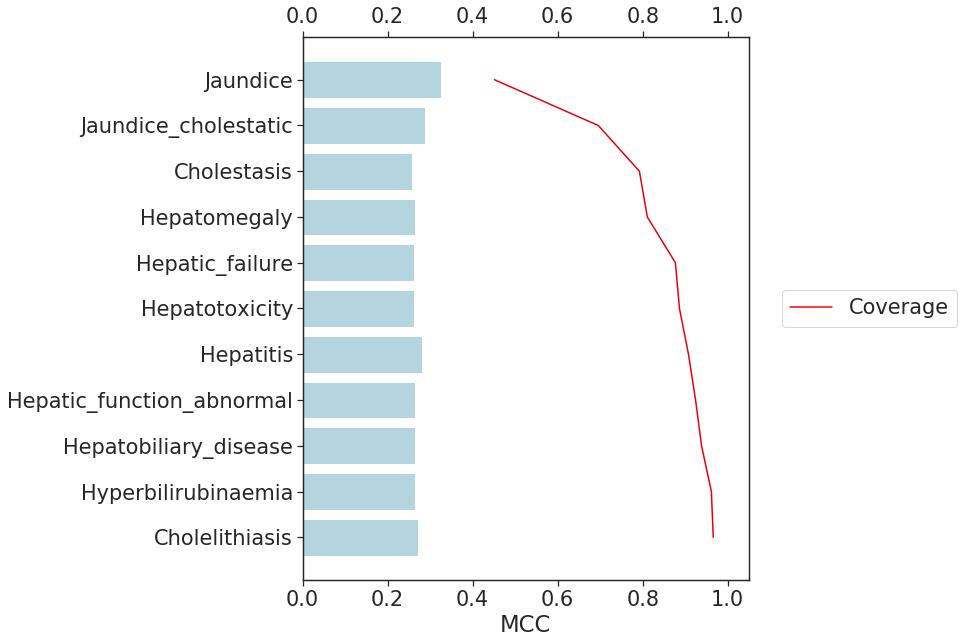

In [100]:
testname = 'mulliner'
colmcc = 'mcc'
rule = 'mv'
colcoverage = 'percentage_AD'
mybarplot(mulliner_performance_DF,testname, colmcc, colcoverage, rule)

figures already exists


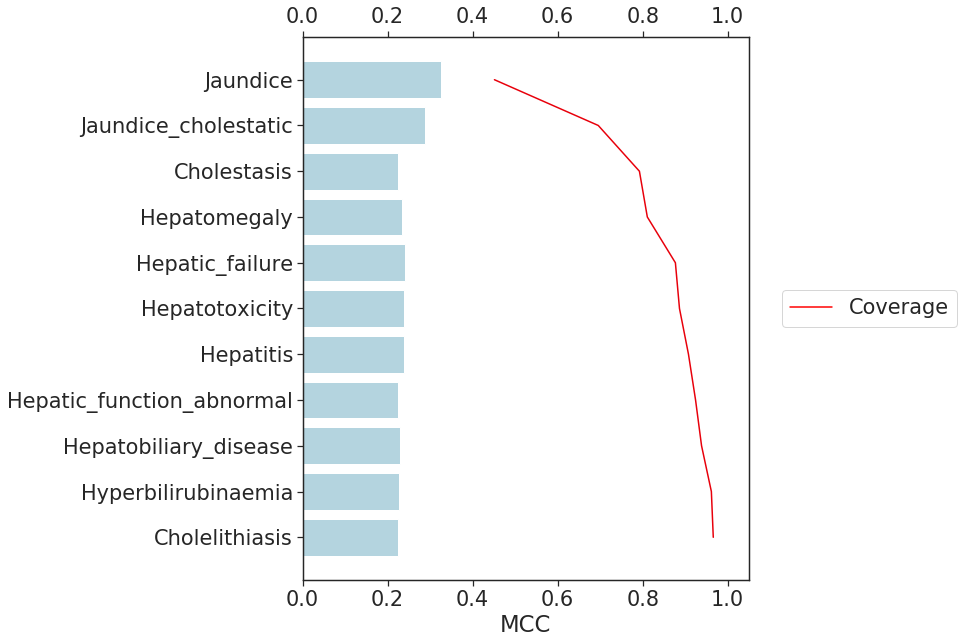

In [101]:
testname = 'mulliner'
colmcc = 'mcc'
rule = 'g'
colcoverage = 'percentage_AD'
mybarplot(mulliner_performance_DF,testname, colmcc, colcoverage, rule)

#### External Validation discussion:
As can be seen from the qualitative results, the external validation performed excellent, giving as sensitivity (sens) X, specificity (spec) X and Matthews correlation coefficient (MCC) X.

## 5.8. Combine (ltkb, obrain, pfizer and mulliner plus no overlap drugbank) Dataset:

In [102]:
drugbank_dict = get_pyramid_combination(pls_drugbank_df, 'endpoint')

In [103]:
preddf = pd.read_csv('predictions_no_optimization_0.15/predictions_drugbank_0.15.tsv', sep='\t')
preddf.head(2)

,parent_nonstd_inkey,Jaundice_cholestatic,Hyperbilirubinaemia,Hepatic_failure,Cholelithiasis,Cholestasis,Hepatitis,Jaundice,Hepatobiliary_disease,Hepatomegaly,Hepatotoxicity,Hepatic_function_abnormal,DILI
0,AAIMHYPMAWJDBG-UHFFFAOYNA-N,0,2,2,2,2,2,2,2,2,0,2,0.0
1,AAKJLRGGTJKAMG-IJFJLPMKNA-O,2,2,2,2,2,2,0,1,2,2,0,1.0


In [104]:
testname = 'drugbank'
testDILIcolumn = 'DILI'

drugbank_performance_DF = pd.DataFrame([])
for i in range(len(drugbank_dict)):
    quality_params_mv, quality_params_g = run_optimization_prediction(drugbank_dict, str(i), preddf,
                                                                      testname, testDILIcolumn)
    quality_params_mv_DF = pd.DataFrame(quality_params_mv)
    quality_params_mv_DF = quality_params_mv_DF.T
    quality_params_g_DF = pd.DataFrame(quality_params_g)
    quality_params_g_DF = quality_params_g_DF.T
    models = drugbank_dict[str(i)]
    models = str(models).lstrip('[').rstrip(']')
    quality_params_mv_DF['models_used_mv'] = models
    quality_params_g_DF['models_used_g'] = models

    qualdf = pd.concat([quality_params_mv_DF, quality_params_g_DF], axis = 1)
    drugbank_performance_DF = pd.concat([drugbank_performance_DF, qualdf],
                                             ignore_index=True, axis=0)

drugbank_performance_DF.columns = ['TP_mv', 'FP_mv', 'TN_mv', 'FN_mv', 'sens_mv', 'spec_mv',
                                       'mcc_mv', 'total_mols_mv', 'molsinAD_mv', 'molsoutAD_mv',
                                       'percentage_AD_mv', 'models_used_mv',
                                       'TP_g', 'FP_g', 'TN_g', 'FN_g', 'sens_g', 'spec_g',
                                       'mcc_g', 'total_mols_g', 'molsinAD_g', 'molsoutAD_g',
                                       'percentage_AD_g', 'models_used_g']

drugbank_performance_DF = drugbank_performance_DF[['models_used_mv', 'TP_mv', 'FP_mv', 'TN_mv',
                                                           'FN_mv', 'sens_mv', 'spec_mv',
                                                           'mcc_mv', 'total_mols_mv', 'molsinAD_mv',
                                                           'molsoutAD_mv', 'percentage_AD_mv', 
                                                           'models_used_g',
                                                           'TP_g', 'FP_g', 'TN_g', 'FN_g', 'sens_g',
                                                           'spec_g', 'mcc_g', 'total_mols_g', 'molsinAD_g',
                                                           'molsoutAD_g', 'percentage_AD_g']]


drugbank_performance_DF['source'] = 'drugbank'
drugbank_performance_DF.index = drugbank_performance_DF.index.set_names(['model_combination'])
drugbank_performance_DF.reset_index(inplace=True)
drugbank_performance_DF['endpoint'] = pls_drugbank_df['endpoint']
drugbank_performance_DF.to_pickle(testname+'_results_optimization/drugbank_performance_optimization_prediction.pkl')
drugbank_performance_DF.to_csv(testname+'_results_optimization/drugbank_performance.csv', sep='\t', index=False)

['Cholestasis']
drugbank_results_optimization/ is created
Consensus predictions molecules: 4066
Consensus predictions molecules inside applicability domain: 1984
Molecules out of AD: 2082
Percentage molecules in of AD: 48.79488440727988
MCC_0:  0.18575809099727758
Sens_0:  0.5182724252491694
Spec_0:  0.6780028943560058
MCC_0:  0.18575809099727758
Sens_0:  0.5182724252491694
Spec_0:  0.6780028943560058
['Cholestasis', 'Hepatic_failure']
drugbank_results_optimization/ already exists
Consensus predictions molecules: 4066
Consensus predictions molecules inside applicability domain: 2965
Molecules out of AD: 1101
Percentage molecules in of AD: 72.92179045745203
MCC_1:  0.22704057619292684
Sens_1:  0.5505171042163882
Spec_1:  0.6762295081967213
MCC_1:  0.22704057619292684
Sens_1:  0.5505171042163882
Spec_1:  0.6762295081967213
['Cholestasis', 'Hepatic_failure', 'Jaundice']
drugbank_results_optimization/ already exists
Consensus predictions molecules: 4066
Consensus predictions molecules insi

In [105]:
drugbank_performance_DF.head(2)

,model_combination,models_used_mv,TP_mv,FP_mv,TN_mv,FN_mv,sens_mv,spec_mv,mcc_mv,total_mols_mv,molsinAD_mv,molsoutAD_mv,percentage_AD_mv,models_used_g,TP_g,FP_g,TN_g,FN_g,sens_g,spec_g,mcc_g,total_mols_g,molsinAD_g,molsoutAD_g,percentage_AD_g,source,endpoint
0,0,'Cholestasis',312.0,445.0,937.0,290.0,0.518272,0.678003,0.185758,4066.0,1984.0,2082.0,48.794884,'Cholestasis',312.0,445.0,937.0,290.0,0.518272,0.678003,0.185758,4066.0,1984.0,2082.0,48.794884,drugbank,Cholestasis
1,1,"'Cholestasis', 'Hepatic_failure'",692.0,553.0,1155.0,565.0,0.550517,0.676230,0.227041,4066.0,2965.0,1101.0,72.921790,"'Cholestasis', 'Hepatic_failure'",692.0,553.0,1155.0,565.0,0.550517,0.676230,0.227041,4066.0,2965.0,1101.0,72.921790,drugbank,Hepatic_failure


figures already exists


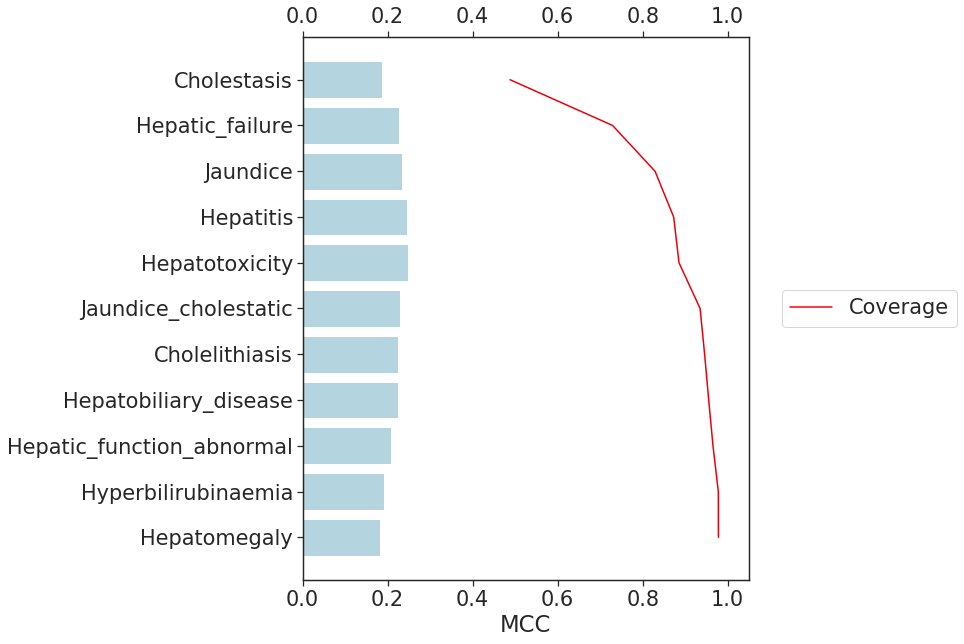

In [106]:
testname = 'drugbank'
colmcc = 'mcc'
rule = 'mv'
colcoverage = 'percentage_AD'
mybarplot(drugbank_performance_DF,testname, colmcc, colcoverage, rule)

figures already exists


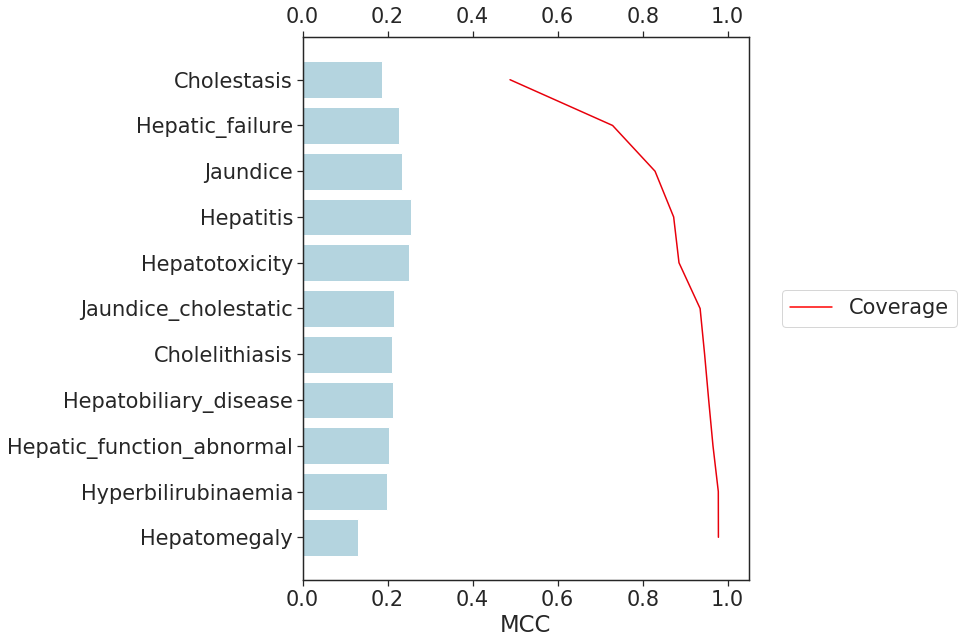

In [107]:
testname = 'drugbank'
colmcc = 'mcc'
rule = 'g'
colcoverage = 'percentage_AD'
mybarplot(drugbank_performance_DF,testname, colmcc, colcoverage, rule)